Ở bài viết trước `module 6 : part 3`, chúng ta đã xây dựng mô hình transfer learning với 10% dữ liệu cho tất cả các class. Qua kết quả đánh giá mô hình, có thể thấy rằng nó đã vượt qua mô hình cơ sở từ [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) với chỉ 10% dữ liệu được train. 

Nhưng bạn có tự hỏi sẽ như thế nào nếu chúng ta sử dụng tất cả dữ liệu đem vào mô hình? Và điều đó sẽ thực hiện trong dự án này. Chúng ta sẽ xây dựng mô hình Food Vision với đầy đủ tập dữ liệu từ 101 Food (có khoảng 75750 hình ảnh train, và 25250 hình ảnh test). 

Lần này, chúng ta có mục tiêu sẽ đánh bại [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), một bài báo năm 2016 sử dụng neural network được train trong 2-3 ngày để đạt được độ chính xác top 1 là 77,4%.


|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

<small>*Bảng so sánh sự khác biệt giữa Food Vision Big (sổ này) và Food Vision mini (sổ trước).*</small>

Cùng với việc cố gắng đánh bại bài báo DeepFood, chúng ta sẽ tìm hiểu về hai phương pháp để cải thiện đáng kể tốc độ train cho mô hình : 
+ Prefetching
+ Mixed precision training

Nội dung bài viết này gồm : 
1. Sử dụng Bộ dữ liệu TensorFlow để tải xuống
2. Khám phá dữ liệu
3. Tạo hàm tiền xử lý dữ liệu
4. Phân cụm & chuẩn bị tập dữ liệu để lập mô hình (**làm cho tập dữ liệu của chúng ta được load nhanh**)
5. Tạo callback function của mô hình trước khi bắt đầu xây dựng nó. 
6. Thiết lập train độ chính xác hỗn hợp (mixed precision training)
7. Xây dựng mô hình trích xuất đặc trưng
8. Tinh chỉnh mô hình trích xuất đặc trưng
9. Đánh giá mô hình, dự đoán phân tích các yếu tố trong mô hình từ dữ liệu test. 
10. Dự đoán hình ảnh ngẫu nhiên ngoài dữ liệu test




Với bài viết này, chúng ta cần sử dụng GPU, nhưng có một chút khác biệt. Vì chúng ta sẽ sử dụng kỹ thuật train độ chính xác hỗn hợp (mixed precision training) nên bạn cần tiếp cận với những GPU có điểm tương thích trên 7.0. 

Google Colab cung cấp cho chúng ta một số GPU có sẵn gồm K80, P100, T4. Tuy nhiên, chỉ có T4 là tương thích với `mixed precision training` được đánh giá trên 7.0. Do đó, trước khi tiếp tục chúng ta cần đảm bảo rằng chúng ta đã truy cập vào GPU Tesla T4, nếu không bạn vẫn có thể áp dụng như bình thường nhưng nó sẽ không thể tăng tốc cho mô hình train. 

> 🔑 **mixed precision training** : là sự kết hợp giữa kiểu dữ liệu float32 (single precision) và float16 (half-precision) để tăng tốc mô hình train (tăng gấp 3 lần trên GPU hiện đại). 

Kiểm tra GPU hiện tại trên google colab. 


In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-0c6e9667-4e70-965a-6f3f-1cf822c3d8f2)


Vì kỹ thuật độ chính xác hỗn hợp đã được giới thiệu trong TensorFlow 2.4.0, hãy đảm bảo rằng bạn đã có ít nhất TensorFlow 2.4.0+.

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.6.0'

Tải `utility_functions` 

In [ ]:
!wget https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py

--2021-09-15 07:45:58--  https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/v4sla7jvi9cltg8/utility_functions.py [following]
--2021-09-15 07:45:58--  https://www.dropbox.com/s/raw/v4sla7jvi9cltg8/utility_functions.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6fdb5f3b467fded16411c54262.dl.dropboxusercontent.com/cd/0/inline/BWNNFQH6nIjr896spR3y2j3ktENNCTYENP-dChdg5KEH4wcQCnHIXvt0JmuQk6CIzivQkrsii-BT-cYntFmSr4BjMT0oBA7sP2kVnJ_JeszOjkNf5I5-OcdFL5neVJKA9KXzNYyrn8p71aCZm7HQc9xO/file# [following]
--2021-09-15 07:45:58--  https://uc6fdb5f3b467fded16411c54262.dl.dropboxusercontent.com/cd/0/inline/BWNNFQH6nIjr896spR3y2j3ktENNCTYENP-dChdg5KEH4wcQCnHIXvt0JmuQk6CIzi

In [ ]:
from utility_functions import compare_history,create_tensorboard_callback,plot_confusion_matrix,plot_loss_curves,unzip_file,walk_through_directory

## 1. Sử dụng bộ dữ liệu TensorFlow để tải dữ liệu xuống 

Ở những bài trước, chúng ta đã tải xuống hình ảnh đồ ăn của mình (từ bộ dữ liệu Food101) từ cloud storage. Và đây là quy trình làm việc điển hình bạn sẽ sử dụng nếu bạn đang làm việc trên tập dữ liệu của riêng mình. Tuy nhiên, có một cách khác để chuẩn bị sẵn bộ dữ liệu để sử dụng với TensorFlow. Đối với nhiều bộ dữ liệu phổ biến nhất trong thế giới học máy (thường được gọi và sử dụng làm điểm chuẩn). Bạn có thể truy cập chúng thông qua Bộ dữ liệu [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

**TensorFlow Datasets** là  một nơi dành cho các bộ dữ liệu học máy đã được chuẩn bị và sẵn sàng để sử dụng. 

Tại sao sử dụng Bộ dữ liệu TensorFlow?
+ Tải xuống dữ liệu có sẵn trong Tensors
+ Thực hành trên các bộ dữ liệu được thiết lập tốt
+ Thử nghiệm với các kỹ thuật tải dữ liệu khác nhau (giống như chúng ta sẽ sử dụng trong notebook này)
+ Thử nghiệm nhanh các tính năng TensorFlow mới (chẳng hạn như train độ chính xác hỗn hợp). 

Tại sao *không* sử dụng Bộ dữ liệu TensorFlow?
+ Các tập dữ liệu là tĩnh (chúng không thay đổi, giống như các tập dữ liệu trong thế giới thực)
+ Có thể không phù hợp với vấn đề cụ thể  (nhưng vẫn rất đáng để thử nghiệm)

Để bắt đầu sử dụng Tập dữ liệu TensorFlow, chúng ta sẽ import `tensorflow_datasets`




In [ ]:
import tensorflow_datasets as tfds

Để tìm tất cả các tập dữ liệu có sẵn trong TensorFlow Datasets, chúng ta có thể sử dụng phương thức `list_builders()`.


In [ ]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_r

Sau đó, chúng ta sẽ kiểm tra xem `food101` có thuộc danh sách trong tập dữ liệu trên hay không. 

In [ ]:
if "food101" in tfds.list_builders() : 
  print("food101 nằm trong tập dữ liệu Tensors")
else : 
  print("Không tìm thấy food101")

food101 nằm trong tập dữ liệu Tensors


Để kết nối đến tập dữ liệu Food101 từ TFDS, chúng ta có thể sử dụng phương thức `tfds.load()`.

Trong phương thức này, sẽ có một số tham số như sau : 
+ `name` (str) : Tên tập dữ liệu (VD : `food101`). 
+ `split` (list, optional) : Tách dữ liệu ra thành các phần khác nhau (VD: `['train', 'validation']`)
+ `shuffle_files` (bool) : Liệu có xáo trộn dữ liệu hay không, mặc định là `False`. 
+ `as_supervised` (bool) : `True` để download dữ liệu dươi dạng ((data, label)), hoặc `False` dưới dạng dictionary. 
+ with_info (bool) : `True` để tải dữ liệu đi kèm với thông tin về dữ liệu đó. 

In [ ]:
(train_data, test_data), dataset_info = tfds.load("food101",
          split=["train", "validation"],
          shuffle_files=True,
          as_supervised=True,
          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteK8KYJR/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteK8KYJR/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Bây giờ chúng ta sẽ lấy thông tin từ tập dữ liệu của, bắt đầu với tên các class.

Lấy tên class từ tập dữ liệu TensorFlow Datasets thông qua biến "dataset_info" (bằng cách sử dụng tham số `as_supervised = True` trong phương thức `tfds.load()`, lưu ý: điều này sẽ chỉ hoạt động đối với tập dữ liệu được giám sát trong TFDS).

Chúng ta có thể truy cập đến tên class của một tập dữ liệu cụ thể bằng cách sử dụng thuộc tính `dataset_info.features` và truy cập thuộc tính tên của khóa "label".


In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [ ]:
dataset_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = dataset_info.features["label"].names
print(class_names[:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


## 2. Khám phá dữ liệu

Chúng ta sẽ tìm hiểu chi tiết bên trong tập dữ liệu này: 
+ Hình dạng của dữ liệu input 
+ Kiểu dữ liệu input 
+ Label của input trong như thế nào? Liệu nó đã được one-hot hay là label-encoded (một số đại diện cho tên của label) 
+ Label có khớp với tên class hay không.

Để thực hiện, chúng ta hãy lấy một mẫu đầu tiên ra khỏi dữ liệu train (sử dụng phương thức `.take(count)`).

In [ ]:
for image, label in train_data.take(1):
  print(f"image shape: {image.shape}")
  print(f"image dtype: {image.dtype}")
  print(f"label: {label}")
  print(f"tên class: {class_names[label]}")

image shape: (384, 512, 3)
image dtype: <dtype: 'uint8'>
label: 97
tên class: takoyaki


Bởi vì chúng ta đã sử dụng tham số `shuffle=True` trên `tfds.load()` nên dữ liệu đã được không theo thứ tự như tập dữ liệu gốc. Chính vì vậy mỗi lần gọi phương thức `take()` như trên nó sẽ trả về một dữ liệu khác nhau.

Tensor của hình ảnh trong TFDS sẽ như thế nào? 

In [ ]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

Giá trị lớn nhất và nhỏ nhất trong tensor? 

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Có thể thấy bộ dữ liệu hình ảnh có giá trị trong phạm vi từ 0 đến 255, và có kiểu dữ liệu `uint8`

### Hiển thị hình ảnh bất kỳ

Quá trình khám phá dữ liệu không thể thiếu bước biểu diễn dữ liệu dưới dạng đồ thị hoặc hình ảnh. Do đó, chúng ta sẽ hiển thị hình ảnh qua biến `image` ở trên. 

In [ ]:
import matplotlib.pyplot as plt

(-0.5, 511.5, 383.5, -0.5)

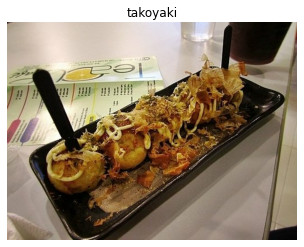

In [ ]:
plt.imshow(image)
plt.title(f"{class_names[label]}")
plt.axis(False)

## 3. Tạo hàm tiền xử lý dữ liệu

Ở những phần trước, chúng ta sử dụng phương thức `tf.keras.preprocessing.image_dataset_from_directory()` đưa đường dẫn của folder chứa ảnh đến để nó thực hiện tiền xử lý dữ liệu giúp chúng ta. 

Tuy nhiên, bởi vì trong project này, chúng ta thực sự không sử dụng folder tải lên trên notebook mà thay vào đó download tập dữ liệu này từ Tensorflow datasets, cho nên có một số bước tiền xử lý mà chúng ta phải thực hiện trước khi nó sẵn sàng tạo mô hình.

Cụ thể hơn, dữ liệu của chúng ta hiện là:
+ Kiểu dữ liệu `uint8` 
+ Kích thước giữa các hình chưa được đồng bộ 
+ Chưa được chuẩn hóa (đưa về 0 -1)

Trái lại, mô hình thường thích dữ liệu : 
+ Kiểu `float32` 
+ Tất cả hình ảnh phải có cùng kích thước
+ Dữ liệu được chuẩn hóa 

Để thực hiện điều này, chúng ta sẽ tạo  hàm `preprocessing_image()` với các chức năng sau : 
+ Resize lại hình ảnh với `td.image.resize()`
+ Chuyển đổi kiểu dữ liệu về `float32` với `tf.cast()`

> 🔑 **Lưu ý**: Trong bài viết này, chúng ta sẽ sử dụng mô hình `EfficientNet`, các dữ liệu khi được đưa vào mô hình này sẽ được chuẩn hóa bởi layer có sẵn của nó. Cho nên chúng ta không cần phải thực hiện bước này trong `preprocessing_image()`. Tuy nhiên, đối với những mô hình khác không được chuẩn hóa bên trong nó, bạn có thể thêm một bước là lấy tất cả giá trị của hình ảnh đó chia cho 255. hoặc tạo một layer chuẩn `tf.keras.experimental.preprocessing.Rescaling()` 


In [ ]:
import tensorflow as tf

In [ ]:
def preprocessing_image(image, label, image_shape=(224,224)) : 
    """
    Parameters : 
    image : an tensor of image 
    label : the label-encoded of image
    image_shape (default (224,224)) : The size of image following with width, height
    """
    image = tf.image.resize(image, size=image_shape)
    image = tf.cast(image,dtype=tf.float32)
    # Vì label trong tập dữ liệu là label-encoded, chúng ta sẽ one-hot để sau này mô hình có thể học và dự đoán xác suất trên từng class
    return image, label

In [ ]:
print(f"""
  image shape :{image.shape}
  image dtype : {image.dtype}  
  image : {image}
""")
preprocessed_img, label =  preprocessing_image(image, label)
print(f"""
  image shape :{preprocessed_img.shape}
  image dtype : {preprocessed_img.dtype}  
  image: {preprocessed_img}
""")


  image shape :(384, 512, 3)
  image dtype : <dtype: 'uint8'>  
  image : [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]

 [[ 78  58  49]
  [ 96  76  67]
  [122 102  93]
  ...
  [191 183 162]
  [188 175 156]
  [172 157 136]]

 ...

 [[162 140 117]
  [164 142 119]
  [169 147 126]
  ...
  [  5   5   5]
  [  6   6   6]
  [  6   6   6]]

 [[168 146 123]
  [170 148 125]
  [176 154 131]
  ...
  [  5   5   5]
  [  6   6   6]
  [  6   6   6]]

 [[173 151 128]
  [176 154 131]
  [182 160 137]
  ...
  [  4   4   4]
  [  6   6   6]
  [  6   6   6]]]


  image shape :(224, 224, 3)
  image dtype : <dtype: 'float32'>  
  image: [[[ 56.23469    32.591835   27.877552 ]
  [ 98.16328    75.16328    68.50001  ]
  [121.62245   101.62245    91.63265  ]
  ...
  [191.72456   191.36736   170.93883  ]
  [202.18863   196.9743    176.90286  ]
  [185.918  

Hình ảnh input được chuyển đổi từ `uint8` thành `float32` và được resize lại từ hình dạng hiện tại của nó thành `(224, 224, 3)`.

(-0.5, 223.5, 223.5, -0.5)

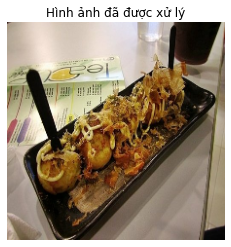

In [ ]:
# chia cho 255 (cho khả năng dung nạp matplotlib)
plt.imshow(preprocessed_img / 255.)
plt.title("Hình ảnh đã được xử lý")
plt.axis(False)

## 3. Phân cụm & chuẩn bị tập dữ liệu để lập mô hình (**làm cho tập dữ liệu của chúng ta được load nhanh**)

Trước khi đưa dữ liệu vào mô hình, chúng ta sẽ phải đưa chúng ta thành các cụm vì không thể nào mô hình trong một thời điểm có thể train được toàn bộ 75720 hình ảnh vì lý do bộ nhớ cũng như hiệu suất xử lý. Do đó, Chúng ta sẽ biến dữ liệu của từ 101.000 hình ảnh gồm cả train và test thành từng cụm với mỗi cụm gồm 32 cặp hình ảnh và label tương ứng với dữ liệu đó. Điều này cho phép mô hình fit được dữ liệu phù hợp trên GPU. 

Để làm điều này một cách hiệu quả, chúng ta sẽ tận dụng một số phương pháp từ API [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Nguồn** :  Để tải dữ liệu theo cách hiệu quả nhất có thể, xem tài liệu TensorFlow trên [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Đặc biệt, chúng ta sẽ sử dụng : 
+  [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) : ánh xạ một hàm được xác định trước đến một tập dữ liệu đích (VD : ánh xạ `preprocessing_image` vào tensor hình ảnh). 
+ [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) : xáo trộn ngẫu nhiên các phần tử của tập dữ liệu mục tiêu với `buffer_size` (`buffer_size` là kích thước mẫu bị xáo trộn. Lý tưởng nhất là `buffer_size` có cùng với kích thước dữ liệu nhưng điều này sẽ chiếm bộ nhớ) 
+ [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) : đưa thành phần của tập dữ liệu đích thành từng cụm (kích thước trong mỗi cụm được định nghĩa `batch_size`, thường là 32)
+  [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) : chuẩn bị các cụm dữ liệu tiếp theo trong khi các cụm dữ liệu khác đang được tính toán ( điều này giúp cải thiện tốc độ load dữ liệu nhưng sẽ tốn bộ nhớ ). 
+ (Thêm)  [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) : lưu các phần tử trong tập dữ liệu đích  vào bộ nhớ đệm (lưu dữ liệu để sử dụng sau này), tiết kiệm thời gian load (sẽ chỉ hoạt động nếu tập dữ liệu của đủ nhỏ để phù hợp với bộ nhớ, ram có sẵn trên Colab tiêu chuẩn chỉ có 12GB bộ nhớ)


**Những điều cần lưu ý**:
 
+ Không thể tạo hàng loạt các cụm chứa dữ liệu chưa được đồng bộ(ví dụ: các kích thước hình ảnh khác nhau, trước tiên cần phải resize lại thông qua hàm `preprocess_img()`).  
+ `shuffle()` giữ một bộ đệm về số lượng hình ảnh được phép truyền qua để nó trộn dữ liệu, lý tưởng là con số này sẽ có cùng với số mẫu trong bộ train. Tuy nhiên, nếu tập dữ liệu train quá lớn, bộ đệm này có thể làm tràn bộ nhớ. Thông thường, chúng ta nên sử dụng từ 1000 đến 10000.  
+ Đối với các phương thức gọi số luồng chạy song song `num_parallel_calls` với tham số có sẵn như là `map()`, đặt nó thành `num_parallel_calls = tf.data.AUTOTUNE` cải thiện đáng kể tốc độ 
+ Không thể sử dụng `cache()` nếu tập dữ liệu không thể phù hợp với bộ nhớ. 

> 📝 Ánh xạ hàm tiền xử lý dữ liệu qua tập dữ liệu -> shuffle dữ liệu -> Đưa dữ liệu vào từng cụm và song song với quá trình này, chắc chắn rằng chuẩn bị cụm tiếp theo (prefetch) để khi xử lý xong cụm này, nó ngay lập tức nhảy qua cụm tiếp theo mà không cần mất thời gian xử lý đưa hình ảnh vào cụm.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

In [ ]:
# Train data
# Ánh xạ hàm preprocessing_image đến tập dữ liệu train 
train_data = train_data.map(map_func=preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)
# Xáo trộn dữ liệu, đưa chúng vào theo từng cụm đồng thời chuẩn bị dữ liệu cho cụm sau 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# =============================
# Test data 
# Ánh xạ hàm preprocessing_image đến tập dữ liệu train 
test_data = test_data.map(map_func=preprocessing_image, num_parallel_calls=tf.data.AUTOTUNE)
# Với tập dữ liệu test, chúng ta không cần xáo trộn dữ liệu, chỉ cần đưa chúng về từng cụm và chuẩn bị cụm tiếp theo
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Hình dạng của dữ liệu là một `tuple` của (`image`, `label`) với kiểu dữ liệu `(tf.float32, tf.int64)`

> 🔑 **Lưu ý**: Bạn có thể bỏ qua phương thức `prefetch()` tại khâu cuối cùng của quá trình trên. Tuy nhiên, nó sẽ load dữ liệu chậm hơn đáng kể khi mô hình đưa dữ liệu vào trước khi tiến hành học. Vì vậy, hầu hết các đường dẫn vào  dữ liệu input của bạn nên kết thúc bằng lệnh gọi đến `prefecth()`. 



## 5. Tạo callback function của mô hình trước khi bắt đầu xây dựng nó

Vì chúng ta sẽ train trên một lượng lớn dữ liệu và quá trình train này có thể mất nhiều thời gian, nên thiết lập một số hàm callback cho mô hình để chúng ta chắc chắn rằng mô hình sẽ ghi lại quá trình train vào trong các log. Điều này cực kỳ quan trọng để giúp chúng ta có thể xử lý nếu có bất thường hoặc sự cố nào xảy ra trong quá trình mô hình train. 

Chúng ta sẽ sử dụng 2 callbacks function : 
+ `tf.keras.callbacks.TensorBoard()` : cho phép chúng ta theo dõi lịch sử train của mô hình, và cũng giúp so sánh với các mô hình train khác. 
+ `tf.keras.callbacks.ModelCheckPoint()` : lưu tiến trình của mô hình trong các khoảng khác nhau, vì vậy chúng ta có thể load và sử dụng lại sau này mà không cần phải train lại. 
  + Check point cũng hữu ích để chúng ta có thể bắt đầu tinh chỉnh mô hình của mình tại một thời điểm cụ thể và hoàn tác về trạng thái trước đó nếu việc tinh chỉnh không mang lại hiệu quả. 

TensorBoard callback  đã được xây dựng sẵn trong `utility_functions`, bạn có thể sử dụng lại mà không cần viết thêm hàm định nghĩa về nó. 

Chúng ta sẽ viết ModelCheckpoint Callback 


 

In [ ]:
from utility_functions import create_tensorboard_callback
import os 

checkpoint_path = "model_checkpoints/efficientnetb0_feature_extraction.ckpt"

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor="val_accuracy",
                                                      verbose=1, 
                                                      save_best_only=True, 
                                                      save_weights_only=True)

## 6. Thiết lập train độ chính xác hỗn hợp (mixed precision training)

Thông thường, tensor trong TensorFlow mặc định là kiểu dữ liệu `float32` (trừ khi được chỉ định khác). 

Trong khoa học máy tính, `float32` còn được gọi  [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). `32` có nghĩa là nó thường chiếm 32 bit trong bộ nhớ máy tính.

Vì bộ nhớ của GPU là có hạn, do đó nó chỉ có thể xử lý một số float32 tensors cùng một lúc. Để có thể xử lý nhiều tensors hơn trong cùng bộ nhớ như vậy, thay vì để mỗi phần tử chiếm bộ nhớ đến 32 bit, chúng ta có thể  sử dụng kết hợp tensors với `float16` và `float32` để tận dụng bộ nhớ của GPU tốt hơn. 

Đối với tensor ở định dạng float16, mỗi phần tử chiếm 16 bit trong bộ nhớ máy tính. Do đó, nếu sử dụng `mixed precision training` chúng ta có thể tăng tốc độ load dữ liệu lên đến gấp 3 lần so với kiểu dữ liệu `float32`. 

Để được giải thích chi tiết hơn, bạn có thể đọc qua [TensorFlow mixed precision guide] (https://www.tensorflow.org/guide/mixed_pre precision) 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Bởi vì train với độ chính xác hỗn hợp sử dụng kết hợp các loại dữ liệu float32 và float16, bạn có thể thấy tốc độ tăng lên đến 3 lần trên các GPU hiện đại*

> 🔑 **Lưu ý:** Như ở đầu bài viết đã có đề cập, nếu GPU của bạn đang sử dụng không đủ số điểm được đánh giá (7.0), `mixed precision training` sẽ không hoạt động. (Xem: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) trong the mixed precision guide để biết thêm thông tin).

Chúng ta sẽ sử dụng API [`tensorflow.keras.mixed_pre precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) để thực hiện. 

Đầu tiên, chúng ta sẽ import API và sau đó sử dụng phương thức  [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) để thiết lập *dtype policy* thành float16. 



In [ ]:
from tensorflow.keras import mixed_precision

In [ ]:
mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

mô hình của chúng ta sẽ tự động tận dụng các biến `float16` nếu có thể và lần lượt tăng tốc độ train.

## 7. Xây dựng mô hình trích xuất đặc trưng

Bởi vì tập dữ liệu khá lớn, chúng ta sẽ sử dụng mô hình được train trước đó (EfficienetNetB0). Đầu tiên, chúng ta sẽ giữ nguyên các trọng số  (đặc trưng) của mô hình này. 

Nhắc lại, thứ tự cụ thể để sử dụng học chuyển tiếp là: 
+ 1. Xây dựng mô hình trích xuất đặc trưng (chỉ thay đổi layer trên cùng cho phù hợp với output)
+ 2. Train một vài epoch với số layer thấp hơn bị đóng băng (không cho phép thay đổi trọng số của layer đó)
+ 3. Tinh chỉnh một số layer ở trên cùng nếu cần thiết. 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Trước khi tinh chỉnh, cách tốt nhất là đào tạo mô hình trích xuất tính năng với các lớp trên cùng tùy chỉnh.*

Để xây dựng [mô hình trích xuất đặc tính](https://github.com/mthang1801/deep-learning/blob/main/docs/04_transfer_learning_part_1_feature_extractor.ipynb), chúng ta sẽ sử dụng : 
+ Mô hình `EfficientNetB0` từ [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) được train trước trong ImageNet làm mô hình cơ sở. 
+ Tải xuống mô hình này và loại bỏ top layer bằng tham số `include_top = False` để chúng ta có thể tạo các output phù hợp với dữ liệu hiện tại.
+ Cố định các layer trong `base_model` để mô hình tận dụng lại các trọng số đã được train trước đó
+ Compile  mô hình, nếu label chưa được onehot thì sử dụng `loss=sparse_categorical_crossentropy`, còn nếu đã onehot rồi thì `loss=categorical_crossentropy`. Trong trường hợp của chúng ta, chúng ta để label dưới dạng label-encoded trong hàm `preprocessing_image`
+ Fit mô hình trong 3 epoch cùng với sử dụng callback function `TensorBoard` và `ModelCheckpoint`. 

> 🔑 **Lưu ý:** Vì đang sử dụng `mixed precision training`, mô hình cần tách biệt output layer với phần layer còn lại. VD :  `layers.Activation("softmax", dtype=tf.float32)`. Điều này đảm bảo output của mô hình được trả về đúng kiểu `float32` với độ chính xác ổn định  với kiểu dữ liệu `float16` ( chỉ quan trọng đối với tính toán sai số). Xem thêm tại ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model). 

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)


In [ ]:
from tensorflow.keras import Model, Sequential, layers

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
INPUT_SHAPE=(224,224,3)

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
# Tách activation của output layer để có thể định nghĩa kiểu float32 cho activation
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32)(x)
model = Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Trước khi tiến hành `fit` mô hình trên, chúng ta sẽ kiểm tra lại kiểu dữ liệu của các layer trong mô hình. 

In [ ]:
for layer in model.layers : 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


Qua phần trên chúng ta thấy:
+ `layer.name` : Tên của layer
+ `layer.trainable` : liệu một layer có thể train được hay không (tất cả các layer đều có thể train được ngoại trừ efficientnetb0 vì chúng ta đã thiết lập `trainable=False` ở phía trên)
+ `layer.dtype` : kiểu dữ liệu mà layer lưu trữ các biến trong nó.
+ `layer.dtype_policy` : Kiểu dữ liệu layer tính toán bên trong. 

> 🔑 **Lưu ý**: Một layer có thể có kiểu dữ liệu là `float32` nhưng kiểu dữ liệu policy là `mixed_float16` vì nó lưu trữ giá trị của các biến là `float32`(ổn định hơn), nhưng khi thực hiện tính toán nó sẽ sử dụng kiểu `float16`(nhanh hơn). 

Kiểm tra chi tiết kiểu dữ liệu trong `base_model`(efficiennetb0)

In [ ]:
for layer_index, layer in enumerate(model.layers[1].layers) : 
  print(layer_index, layer.name, layer.dtype, layer.dtype_policy)

0 input_1 float32 <Policy "float32">
1 rescaling float32 <Policy "mixed_float16">
2 normalization float32 <Policy "mixed_float16">
3 stem_conv_pad float32 <Policy "mixed_float16">
4 stem_conv float32 <Policy "mixed_float16">
5 stem_bn float32 <Policy "mixed_float16">
6 stem_activation float32 <Policy "mixed_float16">
7 block1a_dwconv float32 <Policy "mixed_float16">
8 block1a_bn float32 <Policy "mixed_float16">
9 block1a_activation float32 <Policy "mixed_float16">
10 block1a_se_squeeze float32 <Policy "mixed_float16">
11 block1a_se_reshape float32 <Policy "mixed_float16">
12 block1a_se_reduce float32 <Policy "mixed_float16">
13 block1a_se_expand float32 <Policy "mixed_float16">
14 block1a_se_excite float32 <Policy "mixed_float16">
15 block1a_project_conv float32 <Policy "mixed_float16">
16 block1a_project_bn float32 <Policy "mixed_float16">
17 block2a_expand_conv float32 <Policy "mixed_float16">
18 block2a_expand_bn float32 <Policy "mixed_float16">
19 block2a_expand_activation float32 

In [ ]:
INITIAL_EPOCH = 3

model_feature_extraction_history = model.fit(
    train_data, 
    steps_per_epoch=len(train_data), 
    epochs=INITIAL_EPOCH,
    validation_data=test_data, 
    validation_steps=int(0.25 * len(test_data)), 
    callbacks=[
              create_tensorboard_callback("transfer_learning","efficientnetb0_feature_extraction"), 
              model_checkpoint_cb
    ]
)

Đã lưu tensorboard vào transfer_learning/efficientnetb0_feature_extraction/15092021-001339


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/3
2368/2368 [==============================] - 318s 116ms/step - loss: 1.8197 - accuracy: 0.5575 - val_loss: 1.2282 - val_accuracy: 0.6778

Epoch 00001: val_accuracy improved from -inf to 0.67782, saving model to model_checkpoints/efficientnetb0_feature_extraction.ckpt
Epoch 2/3
2368/2368 [==============================] - 262s 110ms/step - loss: 1.2920 - accuracy: 0.6689 - val_loss: 1.1294 - val_accuracy: 0.6980

Epoch 00002: val_accuracy improved from 0.67782 to 0.69797, saving model to model_checkpoints/efficientnetb0_feature_extraction.ckpt
Epoch 3/3
2368/2368 [==============================] - 262s 110ms/step - loss: 1.1433 - accuracy: 0.7024 - val_loss: 1.0920 - val_accuracy: 0.7056

Epoch 00003: val_accuracy improved from 0.69797 to 0.70558, saving model to model_checkpoints/efficientnetb0_feature_extraction.ckpt


Chúng ta sẽ tiến hành đánh giá trên toàn bộ dữ liệu test

In [ ]:
result_model_feature_extraction = model.evaluate(test_data)
result_model_feature_extraction

790/790 [==============================] - 84s 107ms/step - loss: 1.0935 - accuracy: 0.7052


[1.0935087203979492, 0.7052277326583862]

Sau khi train 3 epochs, khả năng dự đoán của mô hình đạt độ chính xác khoảng ~71%. 

Và vì mô hình có sử dụng `ModelCheckpoint` callback nên đã lưu lại những trọng số mà mô hình học tốt nhất. Bây giờ, chúng ta sẽ load lại chúng. Để giữ cho `model` không bị thay đổi, chúng ta sẽ tạo một bản sao cho `model` và tiến hành load các weight vào bản sao này. 

### Load và đánh giá trọng số trong model checkpoint

Chúng ta có thể load và đánh giá các giá trị kiểm tra của mô hình theo các bước sau:
+ Tạo bản sao (clone) của mô hình bằng `tf.keras.models.clone_model()` để sao chép mô hình trích xuất đặc trưng với các trọng số được reset. 
+ Gọi phương thức `load_weights()` trên mô hình bản sao và truyền đường dẫn đến nơi lưu giữ các trọng số đã được kiểm tra. 
+ Gọi `evaluate` với dữ liệu test để đánh giá mô hình. 

Các kiểm tra (checkpoint) này rất hữu ích khi bạn thực hiện một thử nghiệm, chẳng hạn như tinh chỉnh mô hình của mình. Trong trường hợp bạn tinh chỉnh mô hình trích xuất đặc trưng của mình và thấy nó không mang lại bất kỳ cải thiện nào, bạn có thể hoàn tác về phiên thời điểm kiểm tra của mô hình của mình.

In [ ]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
cloned_model.load_weights("model_checkpoints/efficientnetb0_feature_extraction.ckpt")

Mỗi lần bạn thực hiện thay đổi đối với mô hình của mình (bao gồm cả việc load các trọng số), bạn phải biên dịch lại.

In [ ]:
cloned_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
results_cloned_model_with_load_weights = model.evaluate(test_data)
results_cloned_model_with_load_weights

790/790 [==============================] - 78s 98ms/step - loss: 1.0935 - accuracy: 0.7052


[1.0935101509094238, 0.7052277326583862]

So sánh kết quả kiểm định của mô hình trên dữ liệu test của bản gốc và bản sao xem chúng có tương đồng với nhau hay không 

In [ ]:
results_cloned_model_with_load_weights == result_model_feature_extraction

False

Ồ, có vẻ như 2 kết quả này không chính xác tuyệt đối, chúng ta sẽ sử dụng `np.isclose()` để đánh giá tương đối giữa 2 giá trị này. 

In [ ]:
import numpy as np 

assert np.isclose(result_model_feature_extraction, results_cloned_model_with_load_weights).all()

OK, 2 giá trị trên đã giống với nhau tương đối

Việc sao chép mô hình chỉ bảo toàn các layer của `dtype_policy` (nhưng không bảo toàn trọng số) vì vậy nếu chúng ta muốn tiếp tục tinh chỉnh với mô hình đã nhân bản, chúng ta có thể sử dụng kiểu dữ liệu mixed precision dtype policy

In [ ]:
for layer in cloned_model.layers[1].layers : 
  print(layer.name, layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">
block1a_se_squeeze float32 <Policy "mixed_float16">
block1a_se_reshape float32 <Policy "mixed_float16">
block1a_se_reduce float32 <Policy "mixed_float16">
block1a_se_expand float32 <Policy "mixed_float16">
block1a_se_excite float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Policy "mixed_float16">
block2a_dwconv_pad float3

### Lưu toàn bộ mô hình thành file 

Chúng ta cũng có thể lưu toàn bộ mô hình bằng phương thức `save()`.

Vì mô hình khá lớn, bạn có thể muốn lưu nó vào Google Drive (nếu bạn đang sử dụng Google Colab) để bạn có thể tải nó vào để sử dụng sau này.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_google_drive_dir = "drive/MyDrive/transfer_learning/101_classes_food_model"
model.save(save_google_drive_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/transfer_learning/101_classes_food_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/transfer_learning/101_classes_food_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Bạn cũng có thể lưu mô hình trực tiếp trên Google Colab

> 🔑**Lưu ý** : Bộ nhớ của Google Colab là tạm thời và mô hình của bạn sẽ tự xóa (cùng với mọi tệp đã lưu khác) khi phiên Colab hết hạn.


In [ ]:
model.save("efficientnetB0_feature_extraction_model")

INFO:tensorflow:Assets written to: efficientnetB0_feature_extraction_model/assets


INFO:tensorflow:Assets written to: efficientnetB0_feature_extraction_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Load mô hình vừa tải xuống

In [ ]:
loaded_model = tf.keras.models.load_model("efficientnetB0_feature_extraction_model")
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Kiểm định dữ liệu test của `loaded_model` xem nó có hoạt động chính xác hay chưa

In [ ]:
result_loaded_model = loaded_model.evaluate(test_data)
result_loaded_model

790/790 [==============================] - 82s 101ms/step - loss: 1.0935 - accuracy: 0.7052


[1.093510389328003, 0.7052277326583862]

So sánh kết quả kiểm định giữa `loaded_model` và `model` 

In [ ]:
assert np.isclose(result_model_feature_extraction, result_loaded_model).all()

`loaded_model` đã hoạt động đúng. 

## 8. Tinh chỉnh mô hình trích xuất đặc trưng

Chúng ta sẽ quay lại với `model` để tiến hành tinh chỉnh mô hình. Nếu như đến phần này, có xảy ra sự cố hoặc bị ngắt kết nối... khiến cho notebook không hoạt động phải train lại từ đầu thì bạn có thể bỏ qua bước train mô hình trên, chỉ cần tải mô hình vừa được save ở trên và tiến hành tinh chỉnh mô hình như dưới đây.

Ở bài viết này sẽ chọn cách tải xuống mô hình để thực hiện tinh chỉnh mô hình. 


In [ ]:
!wget https://www.dropbox.com/s/7m1pspkxbebt6o8/101_classes_food_model.zip

--2021-09-15 00:36:21--  https://www.dropbox.com/s/7m1pspkxbebt6o8/101_classes_food_model.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7m1pspkxbebt6o8/101_classes_food_model.zip [following]
--2021-09-15 00:36:21--  https://www.dropbox.com/s/raw/7m1pspkxbebt6o8/101_classes_food_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce3604c461699dfc337e32ba0ca.dl.dropboxusercontent.com/cd/0/inline/BWIk9zzDGWTxAEruZL2R9tZrRzOdPriB4G-Nu2xITkY2tKei352OxWqNmjBbUG4rBgGUIuxfL6k8NcsbTo8zH-bbhWkz-HOugk5i3HhG-N-3METD7PEDHQb7Bb4_SQJgxSfA7rMWtRT5lo7iRrsP4OpT/file# [following]
--2021-09-15 00:36:22--  https://uce3604c461699dfc337e32ba0ca.dl.dropboxusercontent.com/cd/0/inline/BWIk9zzDGWTxAEruZL2R9tZrRzOdPriB4G-Nu2xITkY2tKei

In [ ]:
unzip_file("101_classes_food_model.zip")

Unzipped file


In [ ]:
loaded_model = tf.keras.models.load_model("101_classes_food_model")

Kiểm tra quá trình đánh giá của mô hình : 

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 81s 100ms/step - loss: 1.0921 - accuracy: 0.7053


[1.0920672416687012, 0.7053465247154236]

Kết quả kiểm định của mô hình được tải xuống đã giống với `model` trên dữ liệu test. 

Có bao nhiêu layer trong `loaded_model`?

In [ ]:
for layer in loaded_model.layers : 
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
activation True


In [ ]:
for layer in loaded_model.layers[1].layers : 
  print(layer.name, layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
bloc

Thiết lập cho phép mọi layer có thể train. 

In [ ]:
for layer in loaded_model.layers : 
  layer.trainable = True
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
activation True


Kiểm tra trong layer `efficientnetB0` đã mở cho phép train chưa 

In [ ]:
for layer in loaded_model.layers[1].layers:   
    print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

Chúng ta sẽ định nghĩa lại `ModelCheckpoint` callback, lần này sẽ chỉ lưu giá trị tốt nhất của  mô hình vì mô hình sắp tới chúng ta sẽ train đến khi nó có kết quả tốt nhất, không cần thiết phải lưu các trọng số nữa vì nó chỉ có ích khi muốn cải thiện mô hình.

In [ ]:
checkpoint_path = "model_checkpoints/model_fine_tune.ckpt"
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, 
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

Hiện tại mô hình học có hơn 200 layer và sử dụng gần 100.000 hình ảnh (75k+ train, 5k+ test), có nghĩa là thời gian train của mô hình có thể sẽ lâu hơn nhiều so với trước đây.

> 🤔 Câu hỏi: Thời gian train là bao lâu?

Trung bình 1 epoch có thể mất đến 5ph, nếu train với 100 epoch thì con số đó rơi vào khoảng 500ph tức là hơn 8 giờ đồng hồ. Trong trường hợp của [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (đường cơ sở mà mô hình sắp tới đây đang cố gắng đánh bại), mô hình hoạt động tốt nhất của họ mất 2-3 ngày để train. 

Bạn thực sự sẽ chỉ biết mất bao lâu khi bạn bắt đầu train qua một vài epoch để ước tính được thời gian tương đối của nó.

> 🤔 **Câu hỏi: ** *Có nên ngừng train khi mô hình không còn tiến bộ nữa không?*

Lý tưởng nhất là khi mô hình của ngừng cải thiện. Nhưng một lần nữa, do bản chất của học sâu, có thể khó biết khi nào chính xác một mô hình sẽ ngừng cải tiến.

May mắn thay, có một giải pháp: gọi lại [`` EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

Hàm callback `EarlyStopping` giám sát hiệu suất mô hình cụ thể (ví dụ:` val_loss`) và khi nó ngừng cải thiện trong một số epoch, sẽ tự động dừng train.

Sử dụng `EarlyStopping` kết hợp với ` ModelCheckpoint` tự động lưu mô hình hoạt động tốt nhất, chúng ta có thể tiếp tục train mô hình của mình với số lượng không giới hạn cho đến khi nó ngừng cải thiện.







In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,verbose=1)

Nếu bạn đang có kế hoạch train các mô hình lớn, thì `ModelCheckpoint` và `EarlyStopping` là hai callback function mà bạn sẽ thường xuyên gặp nhất.

Khi mô hình bắt đầu cho thấy khả năng tiếp thu giảm dần, chúng ta sẽ làm gì để mô hình có thể tiếp thu tốt hơn? Đó chính là `learning_rate`. Nếu learning_rate càng lớn thì mô hình học sẽ lướt qua nhiều kiến thức trong dữ liệu, nhưng khi nó càng nhỏ thì mô hình sẽ học chi tiết hơn, học sâu hơn và lâu hơn. 

Khi `val_loss` ngừng cải thiện trong hai hoặc nhiều epoch, chúng ta sẽ giảm `learning_rate` xuống bằng 5 lần so với số trước đó (ví dụ: 0,001 xuống thành 0.001 / 5 = 0,0002).

Và để đảm bảo `learning_rate` không quá thấp (có thể dẫn đến việc mô hình không học được gì), chúng ta sẽ đặt tạo một learning_rate tối thiểu để nó không thể bước qua là `1e-6`. 


In [ ]:
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
  monitor="val_loss",
  factor=0.1,
  patience=10, 
  verbose=1,
  min_lr=1e-6
)

In [ ]:
FINE_TUNE_EPOCHS = 100
loaded_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

loaded_model_fine_tune_history = loaded_model.fit(
    train_data, 
    steps_per_epoch=len(train_data), 
    epochs=FINE_TUNE_EPOCHS,     
    validation_data=test_data,
    validation_steps=len(test_data), 
    callbacks=[
               create_tensorboard_callback("transfer_learning", "efficientnetb0_feature_extraction"), 
               early_stopping_cb, 
               model_checkpoint_cb,
               reduce_lr_cb
    ]
)

Đã lưu tensorboard vào transfer_learning/efficientnetb0_feature_extraction/15092021-003806


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
2368/2368 [==============================] - 1272s 522ms/step - loss: 0.9187 - accuracy: 0.7538 - val_loss: 0.8164 - val_accuracy: 0.7726

Epoch 00001: val_loss improved from inf to 0.81644, saving model to model_checkpoints/model_fine_tune.ckpt
INFO:tensorflow:Assets written to: model_checkpoints/model_fine_tune.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_fine_tune.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
2368/2368 [==============================] - 1210s 510ms/step - loss: 0.5746 - accuracy: 0.8406 - val_loss: 0.7907 - val_accuracy: 0.7869

Epoch 00002: val_loss improved from 0.81644 to 0.79069, saving model to model_checkpoints/model_fine_tune.ckpt
INFO:tensorflow:Assets written to: model_checkpoints/model_fine_tune.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_fine_tune.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
2368/2368 [==============================] - 1211s 510ms/step - loss: 0.3299 - accuracy: 0.9069 - val_loss: 0.8568 - val_accuracy: 0.7851

Epoch 00003: val_loss did not improve from 0.79069
Epoch 4/100
2368/2368 [==============================] - 1211s 511ms/step - loss: 0.1725 - accuracy: 0.9483 - val_loss: 0.9976 - val_accuracy: 0.7781

Epoch 00004: val_loss did not improve from 0.79069
Epoch 5/100
2368/2368 [==============================] - 1221s 515ms/step - loss: 0.1049 - accuracy: 0.9678 - val_loss: 1.0836 - val_accuracy: 0.7741

Epoch 00005: val_loss did not improve from 0.79069
Epoch 00005: early stopping


In [ ]:
results_loaded_model_fine_tune = loaded_model.evaluate(test_data)
results_loaded_model_fine_tune

790/790 [==============================] - 79s 100ms/step - loss: 1.0836 - accuracy: 0.7741


[1.083551287651062, 0.7740989923477173]

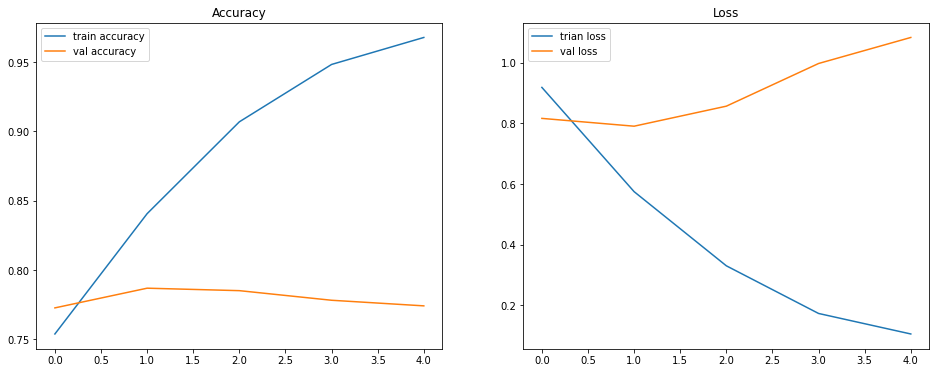

In [ ]:
plot_loss_curves(loaded_model_fine_tune_history)

Sau quá trình train và đánh giá mô hình, chúng ta sẽ lưu mô hình lại. 

In [ ]:
loaded_model_save_dir = "/content/drive/MyDrive/transfer_learning/101_classes_food_fine_tune"
loaded_model.save(loaded_model_save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/transfer_learning/101_classes_food_fine_tune/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/transfer_learning/101_classes_food_fine_tune/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## 9. Đánh giá mô hình, dự đoán và phân tích các yếu tố trong mô hình từ dữ liệu test.

Quá trình thực hiện các bước trên khá dài, rất có thể google colab sẽ ngắt kết nối khiến mọi thứ trở về ban đầu. Chúng ta không thể cứ train lại từ đầu vì thời gian thực hiện công đoạn trên mất rất nhiều thời gian. May mắn thay chúng ta đã lưu mô hình vào Google Drive như bước cuối cùng của phần trên. Lúc này, bạn có thể upload lên, hoặc tạo một zip file gửi lên cloud và tải xuống.

In [ ]:
!wget https://www.dropbox.com/s/4ktbe743z0pj0d5/101_classes_food_fine_tune_model.zip

--2021-09-15 07:56:09--  https://www.dropbox.com/s/4ktbe743z0pj0d5/101_classes_food_fine_tune_model.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4ktbe743z0pj0d5/101_classes_food_fine_tune_model.zip [following]
--2021-09-15 07:56:09--  https://www.dropbox.com/s/raw/4ktbe743z0pj0d5/101_classes_food_fine_tune_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc546ad1d1dba6799d0a81ad3298.dl.dropboxusercontent.com/cd/0/inline/BWNLbKA_mbrNAMEG94OOe31Gn_Y_M8OOtF-Dnf3oM9qPc-QdUNoc0J0eKc5fGZ2zKk2HQJFzc6jeqq_eKWPifCWgigR97EgbPAvobY8hziuY8twbFLOOVCjeml_3xUqdQSKUIISkTuMYo5SixjubLjDj/file# [following]
--2021-09-15 07:56:09--  https://uc546ad1d1dba6799d0a81ad3298.dl.dropboxusercontent.com/cd/0/inline/BWNLbKA_mbrNAMEG94

In [ ]:
unzip_file("101_classes_food_fine_tune_model.zip")

Unzipped file


Sử dụng `tf.keras.models.load_model()` để load mô hình vừa upload lên. 

In [ ]:
loaded_model_fine_tune = tf.keras.models.load_model("101_classes_food_fine_tune_model")
loaded_model_fine_tune

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Kiểm định mô hình vừa được load với tập dữ liệu test để so sánh với mô hình trước đã đúng hay chưa. 

> 🔑**Lưu ý:** Trong trường hợp notebook chưa hoạt động hoặc bị khởi động lại, dữ liệu `test` sẽ bị mất, bạn cần thực hiện lại các nội dung để tạo lại dữ liệu `test`: 
1. Sử dụng Bộ dữ liệu TensorFlow để tải xuống
2. Khám phá dữ liệu
3. Tạo hàm tiền xử lý dữ liệu
4. Phân cụm & chuẩn bị tập dữ liệu để lập mô hình (**làm cho tập dữ liệu của chúng ta được load nhanh**).

**Nhớ rằng đừng chạy mô hình vì chúng ta đã có load mô hình rồi, nhưng nếu bạn chưa có bạn có thể chạy toàn bộ notebook (chuẩn bị sẵn 🍵 để tận hưởng nhé 😆)**


In [ ]:
loaded_model_fine_tune.evaluate(test_data)

790/790 [==============================] - 123s 110ms/step - loss: 1.0836 - accuracy: 0.7741


[1.083551049232483, 0.7740989923477173]

Có vẻ đã giống với mô hình đã được tải xuống. Thay vì sử dụng `test_data`, chúng ta sẽ tải một phiên bản mà phần trước chúng ta đã làm việc với nó. Lý do là `test_data` trong `tfds` không theo thứ tự cố định (nó thay đổi ngẫu nhiên mỗi khi thực thi code trong cell) , trong khi `test_data` trước đây chúng ta giữ nguyên, không xáo trộn dữ liệu nhằm để dễ dàng quan sát và theo dõi. 

In [ ]:
!wget https://www.dropbox.com/s/8pakapzwodimtvw/all_food_classes_10_percent.zip

--2021-09-15 07:58:39--  https://www.dropbox.com/s/8pakapzwodimtvw/all_food_classes_10_percent.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8pakapzwodimtvw/all_food_classes_10_percent.zip [following]
--2021-09-15 07:58:39--  https://www.dropbox.com/s/raw/8pakapzwodimtvw/all_food_classes_10_percent.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce80d1477264bf8edcbb74545d4.dl.dropboxusercontent.com/cd/0/inline/BWOUg-3m-j7Al4591mHvwjsfIA12GSvDrKeNFydg2ufP-5nrfqgXODU7HiLhaWMuZpirvahJJjK9JxVjd9g88QBo3ssPzXHHZZk_AKYSN4lWtkS0sirGh32sI2KVp8egBgNxeBHSxldrGu5zo9fdXZGV/file# [following]
--2021-09-15 07:58:39--  https://uce80d1477264bf8edcbb74545d4.dl.dropboxusercontent.com/cd/0/inline/BWOUg-3m-j7Al4591mHvwjsfIA12GSvDr

In [ ]:
unzip_file("all_food_classes_10_percent.zip")

Unzipped file


> 🔑**Lưu ý**: Chúng ta chỉ quan tâm dữ liệu `test` còn train chúng ta không dùng đến

In [1]:
all_classes_test_dir = "/content/all_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

Để sử dụng API `tf.data.Dataset`,  chúng ta cần load và chuẩn bị hình ảnh với phương thức `tf.keras.preprocessing.image_dataset_from_directory()`

In [ ]:
test_data_all_classes = image_dataset_from_directory(
    all_classes_test_dir,
    image_size=(224,224),
    label_mode="int",
    shuffle=False
)

Found 25250 files belonging to 101 classes.


In [ ]:
test_data_all_classes

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

Kiểu cấu trúc trong `test_data_all_classes` là một tuple `((None, 224, 224, 3), (None,))` với kiểu dữ liệu  `(tf.float32, tf.int32)` 

Với `test_data` là một tuple `((None, 224, 224, 3), (None,))` có kiểu dữ liệu `(tf.float32, tf.int64)`

Cả 2 cấu trúc này đều có cùng kiểu, nên chúng ta có thể đưa `test_data_all_classes` vào mô hình để đánh giá và dự đoán được. 




In [ ]:
class_names = test_data_all_classes.class_names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla']

Kiểm định khả năng dự đoán của mô hình với `test_data_all_classes`

In [ ]:
results_loaded_model_fine_tune = loaded_model_fine_tune.evaluate(test_data_all_classes)
results_loaded_model_fine_tune

790/790 [==============================] - 91s 113ms/step - loss: 1.3493 - accuracy: 0.7610


[1.3492883443832397, 0.7609900832176208]

Mô hình được kiểm định khá tương đồng với mô hình trước. Bây giờ, chúng ta sẽ thực hiện dự đoán mô hình trên `test_data_all_classes`. Vì dữ liệu có 101 class, nên với mỗi dữ liệu được mô hình dự đoán sẽ tạo thành một mảng với 101 phần tử là xác suất của 101 class. Và có tất cả 25250 dữ liệu được đưa vào mô hình. Do đó, mô hình sẽ trả về 25250 kết quả tính toán dưới dạng mảng. 


In [ ]:
y_pred_probs = loaded_model_fine_tune.predict(test_data_all_classes,verbose=1)
y_pred_probs

790/790 [==============================] - 76s 94ms/step


array([[1.9735955e-05, 2.1675705e-05, 3.4982816e-04, ..., 4.7145440e-07,
        6.4711705e-05, 1.3072124e-04],
       [9.9969423e-01, 3.3829738e-11, 6.7177275e-08, ..., 2.9980438e-09,
        3.3637118e-10, 2.7611026e-11],
       [3.5718560e-01, 1.1764673e-09, 2.2964869e-03, ..., 1.8221482e-09,
        1.5964792e-05, 2.4343401e-05],
       ...,
       [1.2444305e-06, 4.6893666e-03, 4.8601214e-12, ..., 3.7578545e-08,
        8.9122605e-06, 7.8863025e-01],
       [2.9462780e-04, 8.8463312e-05, 4.9237242e-05, ..., 5.3543022e-06,
        2.7978903e-10, 9.9521375e-01],
       [6.5390118e-03, 1.0061138e-07, 1.5738268e-06, ..., 2.7079185e-08,
        8.8283684e-07, 9.9070412e-01]], dtype=float32)

Cuối cùng, hình dạng output của quá trình dự đoán này sẽ là : 

In [ ]:
y_pred_probs.shape

(25250, 101)

Để lấy được label dự đoán của hình ảnh dữ liệu đưa vào, chúng ta sẽ lấy vị trí của phần tử nào có giá trị lớn nhất trong mảng đó, hay nói cách khác là tìm xác suất nào lớn nhất thì nó sẽ đại diện cho mảng đó làm label.

In [ ]:
y_pred_labels = tf.argmax(y_pred_probs,axis=1).numpy()
y_pred_labels

array([ 52,   0,  97, ..., 100, 100, 100])

Label dự đoán đã lấy được. Tuy nhiên, vẫn chưa có label thực sự để so sánh. `test_data_all_classes` vừa rồi chúng ta đã sử dụng API `image_dataset_from_directory` để load và phân cụm cho dữ liệu. Bây giờ chúng ta sẽ lấy label của nó bằng cách tạo vòng lặp, đồng thời sử dụng phương thức `unbatch()` để đưa dữ liệu về theo thứ tự ban đầu, không còn gom chúng thành từng cụm nữa. 

In [ ]:
y_true_labels = [] 
for image, label in test_data_all_classes.unbatch() : 
  y_true_labels.append(label.numpy())
y_true_labels[:5]

[0, 0, 0, 0, 0]

OK, label thực sự của dữ liệu `test_data_all_classes` đã có. Chúng ta sẽ thử đánh giá độ chính xác giữa `y_true_labels` và `y_pred_labels` bằng phương thức có sẵn trong `sklearn.metrics.accuracy_score` để xem nó có khớp với quá trình kiểm định mô hình như đã làm hay không. 

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true_labels, y_pred_labels)

0.760990099009901

`accuracy_score` và `results_loaded_model_fine_tune.accuracy` đã giống với nhau. Có vẻ tiến trình thực hiện đang đi đúng hướng 😁. 

Trong `sklearn.metrics` ngoài `accuracy_score` còn một vài phương thức đánh giá độ chính xác cũng như hiệu suất của mô hình. Chẳng hạn như `confusion_matrix`, nhưng nếu sử dụng nó đơn thuần sẽ rất khó hiểu vì chỉ là ma trận mà không có bất kỳ ý nghĩa nào. Cho nên, chúng ta sẽ sử dụng `plot_confusion_matrix` trong `utility_functions` để vẽ matrix được rõ ràng.

Trước tiên, chúng ta cần `import` lại `utility_functions` 

In [3]:
!wget https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py

--2021-09-15 15:50:54--  https://www.dropbox.com/s/v4sla7jvi9cltg8/utility_functions.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/v4sla7jvi9cltg8/utility_functions.py [following]
--2021-09-15 15:50:55--  https://www.dropbox.com/s/raw/v4sla7jvi9cltg8/utility_functions.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d544eb80be9b9406162c03ff9.dl.dropboxusercontent.com/cd/0/inline/BWNvzavOUUkcKDSxagjJi2caPNapNWavGMq_gvv6aiwdhFhekTQyoeOyjmMbWK0-qZcPNU7iERxN4q-VUxHIeNinMnBuML5pkGr7r3GhG0lsKMCdjmLzkRFKRVGPWDHK6d1Afs3MQP4WKYKgczTmtdqp/file# [following]
--2021-09-15 15:50:55--  https://uc7d544eb80be9b9406162c03ff9.dl.dropboxusercontent.com/cd/0/inline/BWNvzavOUUkcKDSxagjJi2caPNapNWavGMq_gvv6aiwdhFhekTQyoeOyjmMbWK0

In [4]:
from utility_functions import plot_confusion_matrix

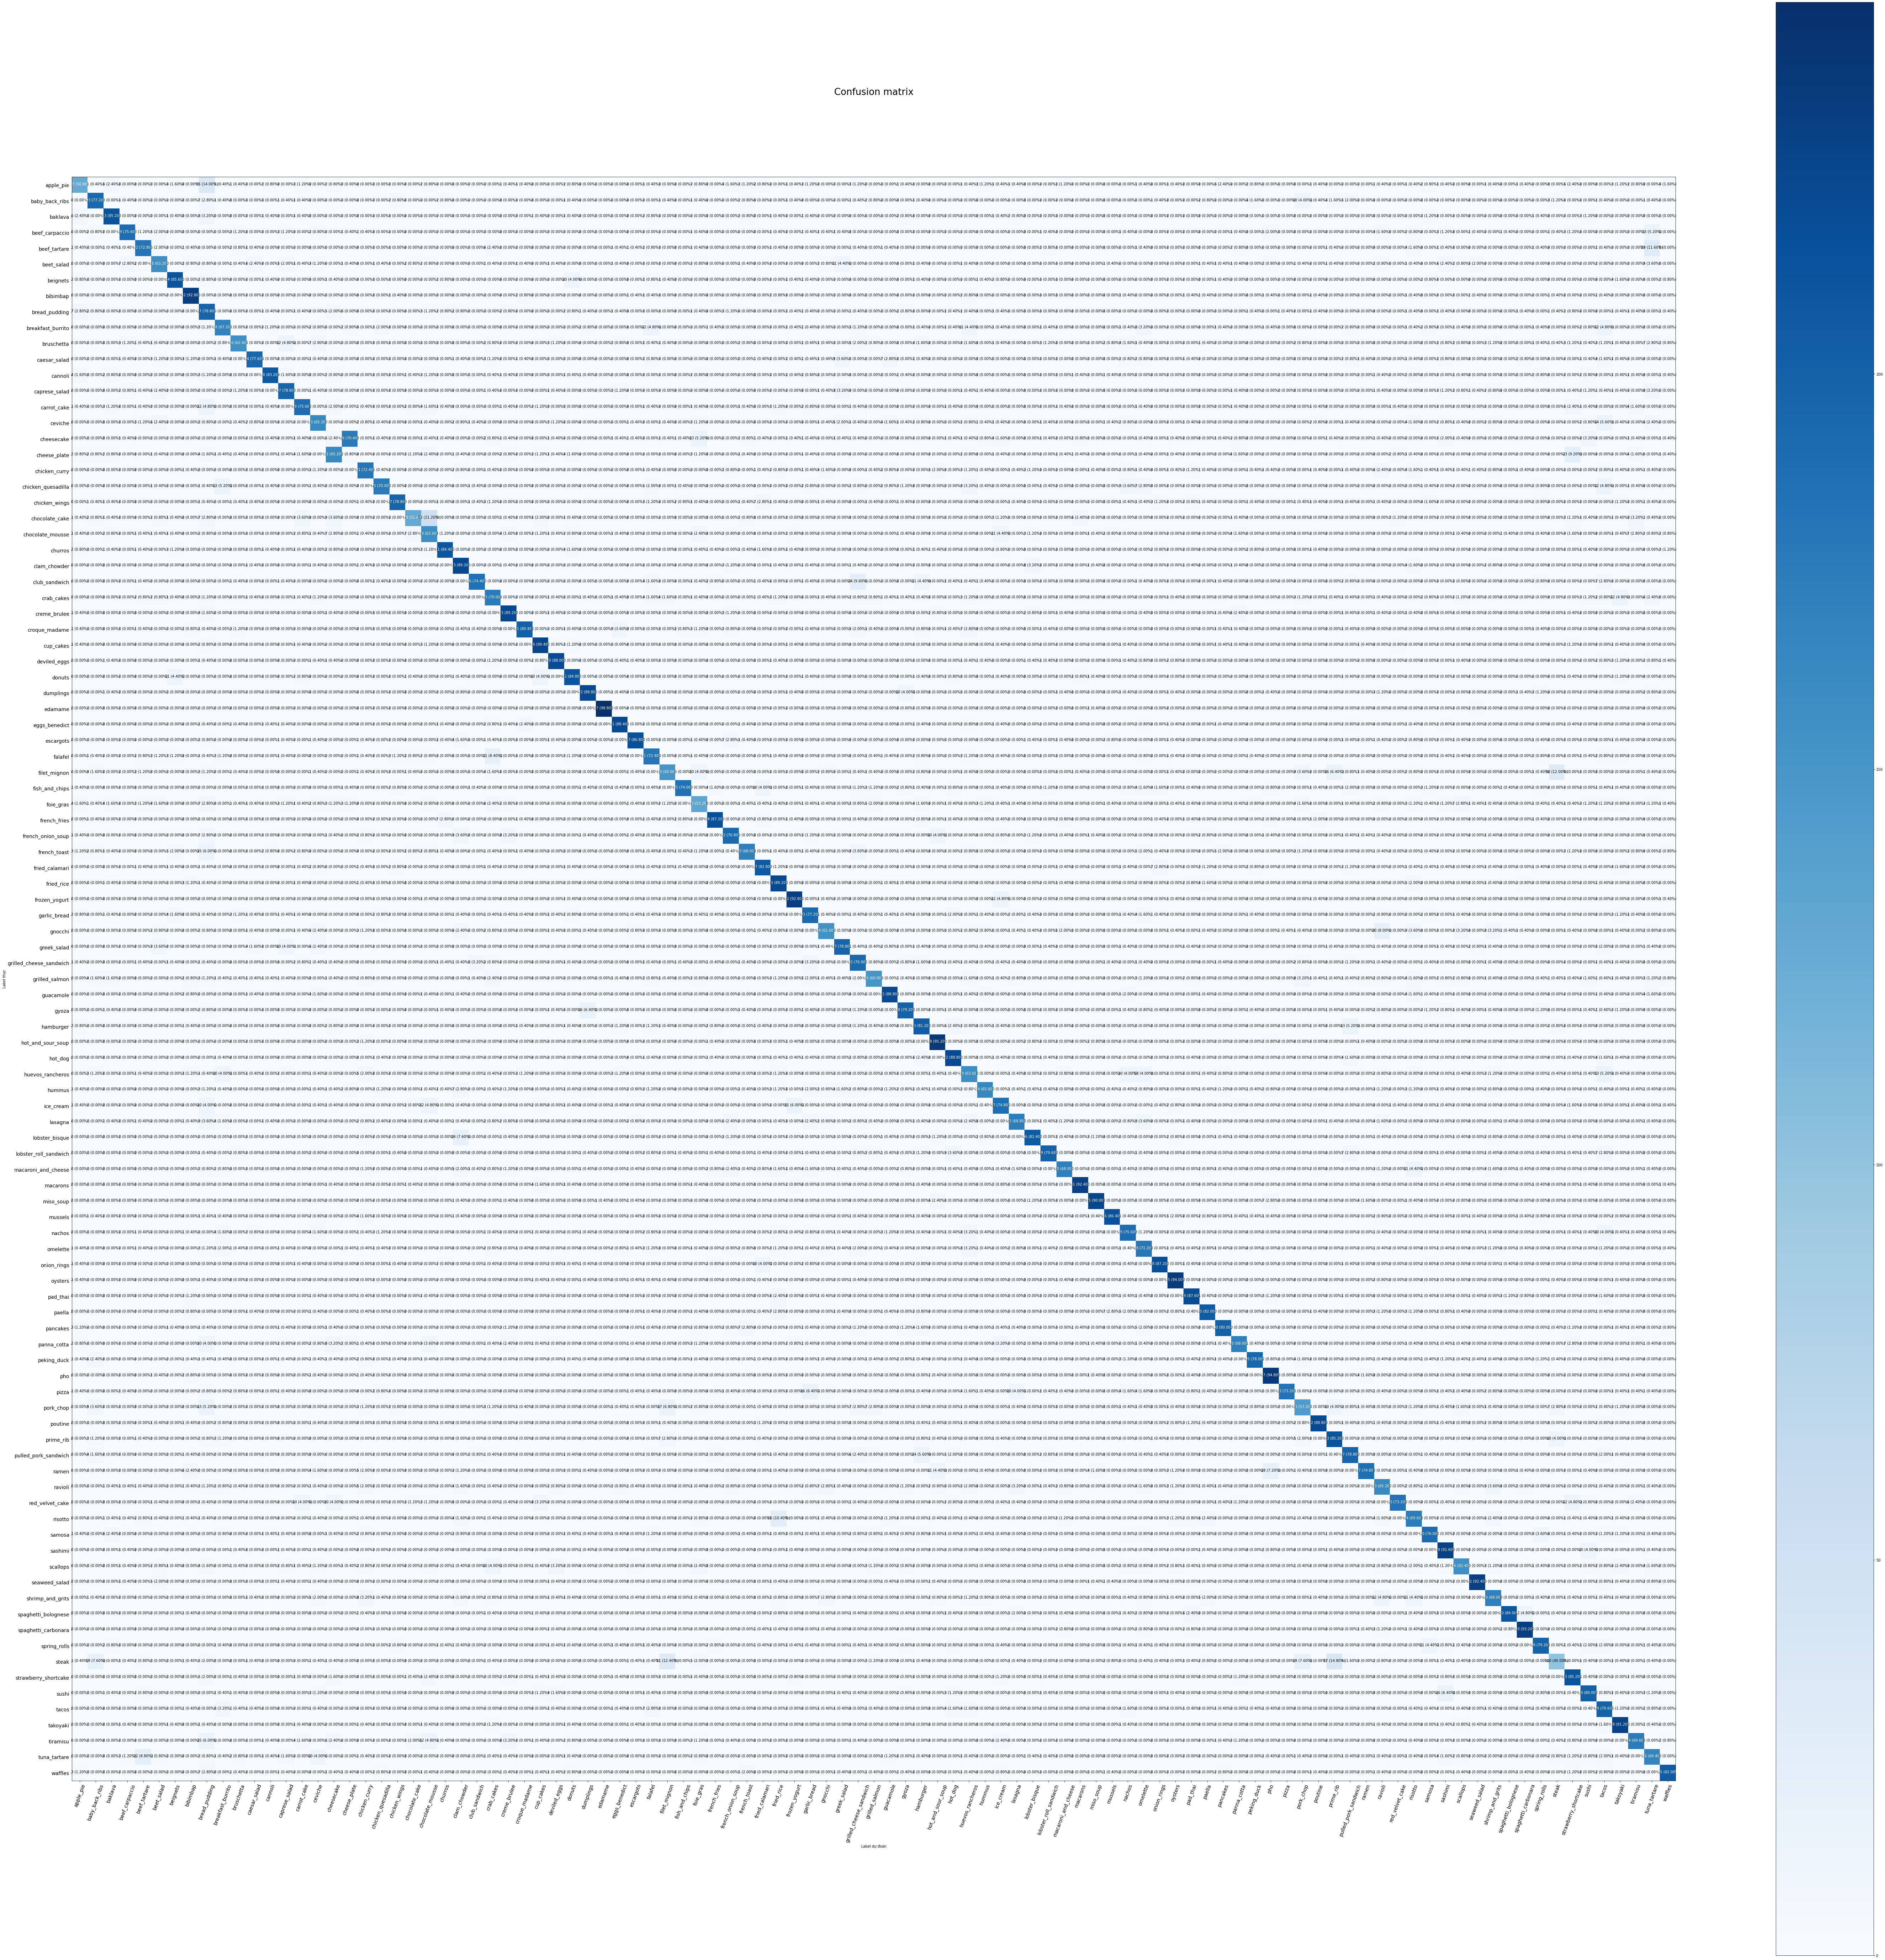

In [ ]:
plot_confusion_matrix(y_true_labels, y_pred_labels, class_names)

Với 101 class, `confusion_matrix` phải scale dữ liệu và số class cho đủ với khung hình, bạn có thể click vào hình để phóng to và quan sát dễ dàng hơn. 

Thêm vào các phương thức đánh giá, chúng ta sẽ sử dụng thêm `classification_report` và output bằng kiểu cấu trúc `dict`

Bạn còn nhớ ý nghĩa của các phương pháp đánh giá trong nó thể hiện điều gì không? 

+ `Precision` : Tỷ lệ dương đúng (TP đoán 1 và đúng) trên tổng số mẫu. Nếu dương đúng càng lớn thì dương sai càng nhỏ (FP đoán 1 và sai) 
+ `Recall` : Tỷ lệ dương đúng (TP) trên tổng số dương đúng (TP) và âm sai (FN) (mô hình dự đoán 0 nhưng sai),  Recall cao hơn dẫn đến ít âm giả. 
+ `F1-score` : Kết hợp giữa `Precision` và `Recall` thành một không gian đo. 1 là tốt nhất, 0 là tệ nhất

Do `F1-score` là sự kết hợp của 2 phương thức trên nên chúng ta sẽ lấy `F1-score` làm thước đo để đánh giá mô hình. 

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
metrics_report_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True)
metrics_report_dict

{'0': {'f1-score': 0.5799086757990868,
  'precision': 0.675531914893617,
  'recall': 0.508,
  'support': 250},
 '1': {'f1-score': 0.75390625,
  'precision': 0.7366412213740458,
  'recall': 0.772,
  'support': 250},
 '10': {'f1-score': 0.7027027027027027,
  'precision': 0.8041237113402062,
  'recall': 0.624,
  'support': 250},
 '100': {'f1-score': 0.8418891170431211,
  'precision': 0.8649789029535865,
  'recall': 0.82,
  'support': 250},
 '11': {'f1-score': 0.8220338983050848,
  'precision': 0.8738738738738738,
  'recall': 0.776,
  'support': 250},
 '12': {'f1-score': 0.8702928870292886,
  'precision': 0.9122807017543859,
  'recall': 0.832,
  'support': 250},
 '13': {'f1-score': 0.7725490196078431,
  'precision': 0.7576923076923077,
  'recall': 0.788,
  'support': 250},
 '14': {'f1-score': 0.7651821862348178,
  'precision': 0.7745901639344263,
  'recall': 0.756,
  'support': 250},
 '15': {'f1-score': 0.6379647749510764,
  'precision': 0.6245210727969349,
  'recall': 0.652,
  'support': 

In [ ]:
f1_scores_dict = {}

for key, value in metrics_report_dict.items() : 
  if key == "accuracy": 
    break
  f1_scores_dict[class_names[int(key)]] = value["f1-score"]

f1_scores_dict

{'apple_pie': 0.5799086757990868,
 'baby_back_ribs': 0.75390625,
 'baklava': 0.8385826771653544,
 'beef_carpaccio': 0.8111587982832618,
 'beef_tartare': 0.7383367139959431,
 'beet_salad': 0.6694915254237288,
 'beignets': 0.8508946322067595,
 'bibimbap': 0.8838095238095238,
 'bread_pudding': 0.5644699140401146,
 'breakfast_burrito': 0.6857142857142857,
 'bruschetta': 0.7027027027027027,
 'caesar_salad': 0.8220338983050848,
 'cannoli': 0.8702928870292886,
 'caprese_salad': 0.7725490196078431,
 'carrot_cake': 0.7651821862348178,
 'ceviche': 0.6379647749510764,
 'cheese_plate': 0.009029345372460496,
 'cheesecake': 0.024096385542168672,
 'chicken_curry': 0.7154150197628457,
 'chicken_quesadilla': 0.7760532150776052,
 'chicken_wings': 0.8491379310344829,
 'chocolate_cake': 0.6262135922330098,
 'chocolate_mousse': 0.5771324863883849,
 'churros': 0.8594704684317719,
 'clam_chowder': 0.7950089126559716,
 'club_sandwich': 0.8211920529801324,
 'crab_cakes': 0.6603773584905661,
 'creme_brulee': 0.

Đây là kết quả `F1-score` được trích ra tử phương pháp `classification_report` dưới dạng dict. Để đánh giá trực quan với sô liệu dày đặc như vậy, chúng ta sẽ vẽ biểu đồ. Nhưng trước tiên, cần phải sắp xếp các giá trị này theo thứ tự. Để sắp xếp các giá trị này, chúng ta sẽ sử dụng `DataFrame` trong thư viện `pandas`. 

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
f1_scores_df = pd.DataFrame({"class_names" : f1_scores_dict.keys(), "probability" : f1_scores_dict.values()}).sort_values(by="probability", ascending=False)
f1_scores_df

class_names  probability
33              edamame     0.991968
63             macarons     0.933333
88        seaweed_salad     0.925852
64            miso_soup     0.910931
91  spaghetti_carbonara     0.908382
..                  ...          ...
8         bread_pudding     0.564470
39            foie_gras     0.558824
93                steak     0.480769
16           cheesecake     0.024096
17         cheese_plate     0.009029

[101 rows x 2 columns]

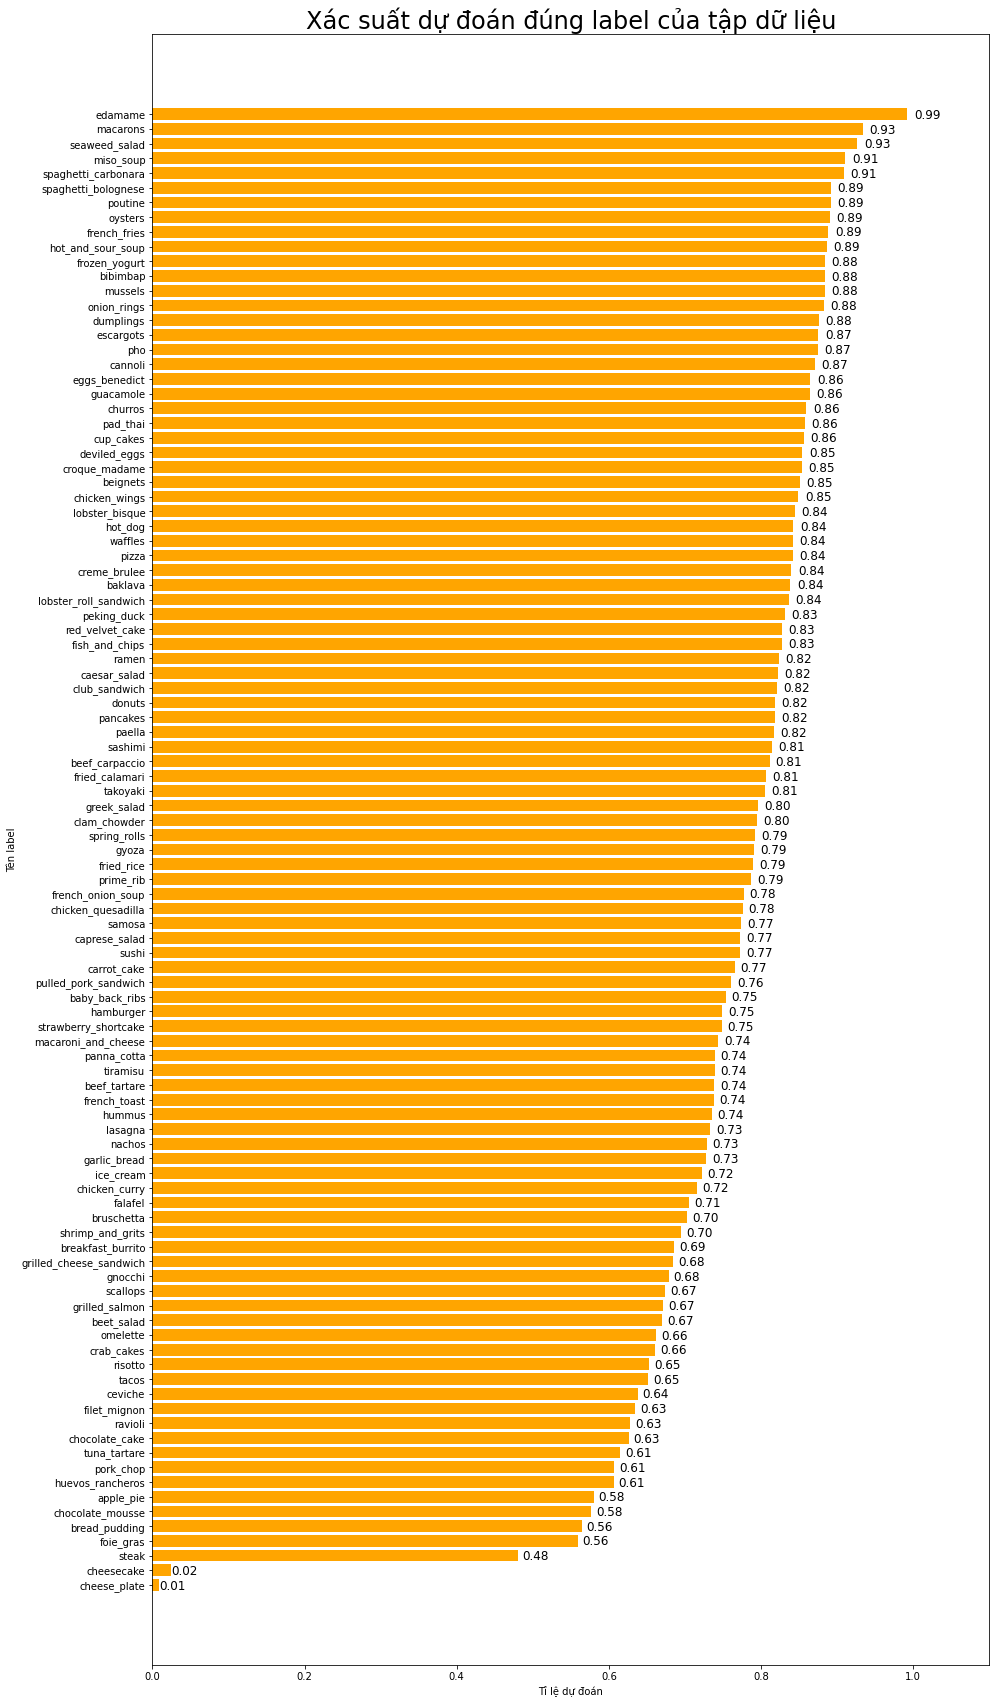

In [ ]:
fig, ax = plt.subplots(figsize=(15,30))
rects = ax.barh(f1_scores_df["class_names"], f1_scores_df["probability"], color="orange")
ax.set_title("Xác suất dự đoán đúng label của tập dữ liệu",fontsize=24)
ax.set_xlabel("Tỉ lệ dự đoán")
ax.set_ylabel("Tên label") 
ax.invert_yaxis()
ax.set_xlim([0,1.1])

for rect in rects : 
  x,y = rect.get_width(), rect.get_y()
  plt.text(x*1.01,y, f"{x:.2f}", ha="left", va="top", fontsize=12)

Từ biểu đồ trên, có thể dễ dàng thấy được mô hình có khả năng dự đoán class nào là tốt nhất, class nào chưa được tốt... 

Ngoài ra, chúng ta sẽ sử dụng `DataFrame` để lập bảng phân tích các yếu tố trong mô hình dự đoán như sau :

Đầu tiên, thu thập tất cả các đường dẫn đến file ảnh trong dữ liệu `test` : 

In [ ]:
import os

image_paths = [] 

for image_path in test_data_all_classes.list_files(os.path.join(all_classes_test_dir, "*", "*")) : 
  image_paths.append(image_path.numpy().decode("utf-8"))

image_paths[:5]

['/content/all_food_classes_10_percent/test/breakfast_burrito/3702900.jpg',
 '/content/all_food_classes_10_percent/test/cheesecake/34970.jpg',
 '/content/all_food_classes_10_percent/test/beef_carpaccio/2152088.jpg',
 '/content/all_food_classes_10_percent/test/lobster_roll_sandwich/2676709.jpg',
 '/content/all_food_classes_10_percent/test/scallops/3639679.jpg']

Tạo bảng tổng hợp về kết quả dự đoán cho từng file ảnh cụ thể :

In [ ]:
results_df = pd.DataFrame({
    "image_path" : image_paths, 
    "predict_label" : y_pred_labels, 
    "true_label" : y_true_labels, 
    "predict_prob" : tf.reduce_max(y_pred_probs,axis=1), 
    "predict_class_name" : [class_names[i] for i in y_pred_labels], 
    "true_class_name" : [class_names[i] for i in y_true_labels], 
    "result" : y_pred_labels == y_true_labels
})

results_df


image_path  ...  result
0      /content/all_food_classes_10_percent/test/brea...  ...   False
1      /content/all_food_classes_10_percent/test/chee...  ...    True
2      /content/all_food_classes_10_percent/test/beef...  ...   False
3      /content/all_food_classes_10_percent/test/lobs...  ...    True
4      /content/all_food_classes_10_percent/test/scal...  ...    True
...                                                  ...  ...     ...
25245  /content/all_food_classes_10_percent/test/lobs...  ...    True
25246  /content/all_food_classes_10_percent/test/file...  ...    True
25247  /content/all_food_classes_10_percent/test/eggs...  ...    True
25248  /content/all_food_classes_10_percent/test/chic...  ...    True
25249  /content/all_food_classes_10_percent/test/fren...  ...    True

[25250 rows x 7 columns]

Tìm top những hình ảnh có xác suất cao nhưng dự đoán sai : 

In [ ]:
top_worst_image_prediction = results_df[results_df["result"] == False].sort_values(by="predict_prob", ascending=False)
top_worst_image_prediction

image_path  ...  result
4106   /content/all_food_classes_10_percent/test/sash...  ...   False
21978  /content/all_food_classes_10_percent/test/guac...  ...   False
4242   /content/all_food_classes_10_percent/test/tira...  ...   False
14035  /content/all_food_classes_10_percent/test/tuna...  ...   False
4158   /content/all_food_classes_10_percent/test/croq...  ...   False
...                                                  ...  ...     ...
19368  /content/all_food_classes_10_percent/test/stea...  ...   False
19779  /content/all_food_classes_10_percent/test/fala...  ...   False
3011   /content/all_food_classes_10_percent/test/file...  ...   False
25196  /content/all_food_classes_10_percent/test/chic...  ...   False
5591   /content/all_food_classes_10_percent/test/waff...  ...   False

[6035 rows x 7 columns]

Top những class được dự đoán sai nhiều nhất và tỉ lệ dự đoán sai : 

In [ ]:
top_worst_class_prediction = results_df.loc[results_df["result"] == False, "true_class_name"].value_counts()
top_worst_class_prediction = pd.DataFrame(top_worst_class_prediction)
top_worst_class_prediction["percentage"] = top_worst_class_prediction["true_class_name"] / 250.
top_worst_class_prediction

true_class_name  percentage
cheese_plate                     248       0.992
cheesecake                       244       0.976
steak                            150       0.600
apple_pie                        123       0.492
chocolate_cake                   121       0.484
...                              ...         ...
spaghetti_carbonara               17       0.068
oysters                           15       0.060
pho                               13       0.052
hot_and_sour_soup                 12       0.048
edamame                            3       0.012

[101 rows x 2 columns]

Top những class được dự đoán nhiều nhất, và tỉ lệ của nó trên tổng số file 

In [ ]:
top_most_classes_prediction = results_df["predict_class_name"].value_counts() 
top_most_classes_prediction = pd.DataFrame(top_most_classes_prediction)
top_most_classes_prediction["percentage"] = top_most_classes_prediction / len(results_df)
top_most_classes_prediction

predict_class_name  percentage
bread_pudding                        448    0.017743
tacos                                361    0.014297
strawberry_shortcake                 319    0.012634
takoyaki                             316    0.012515
fried_rice                           315    0.012475
...                                  ...         ...
red_velvet_cake                      192    0.007604
apple_pie                            188    0.007446
pizza                                185    0.007327
steak                                166    0.006574
chocolate_cake                       162    0.006416

[101 rows x 2 columns]

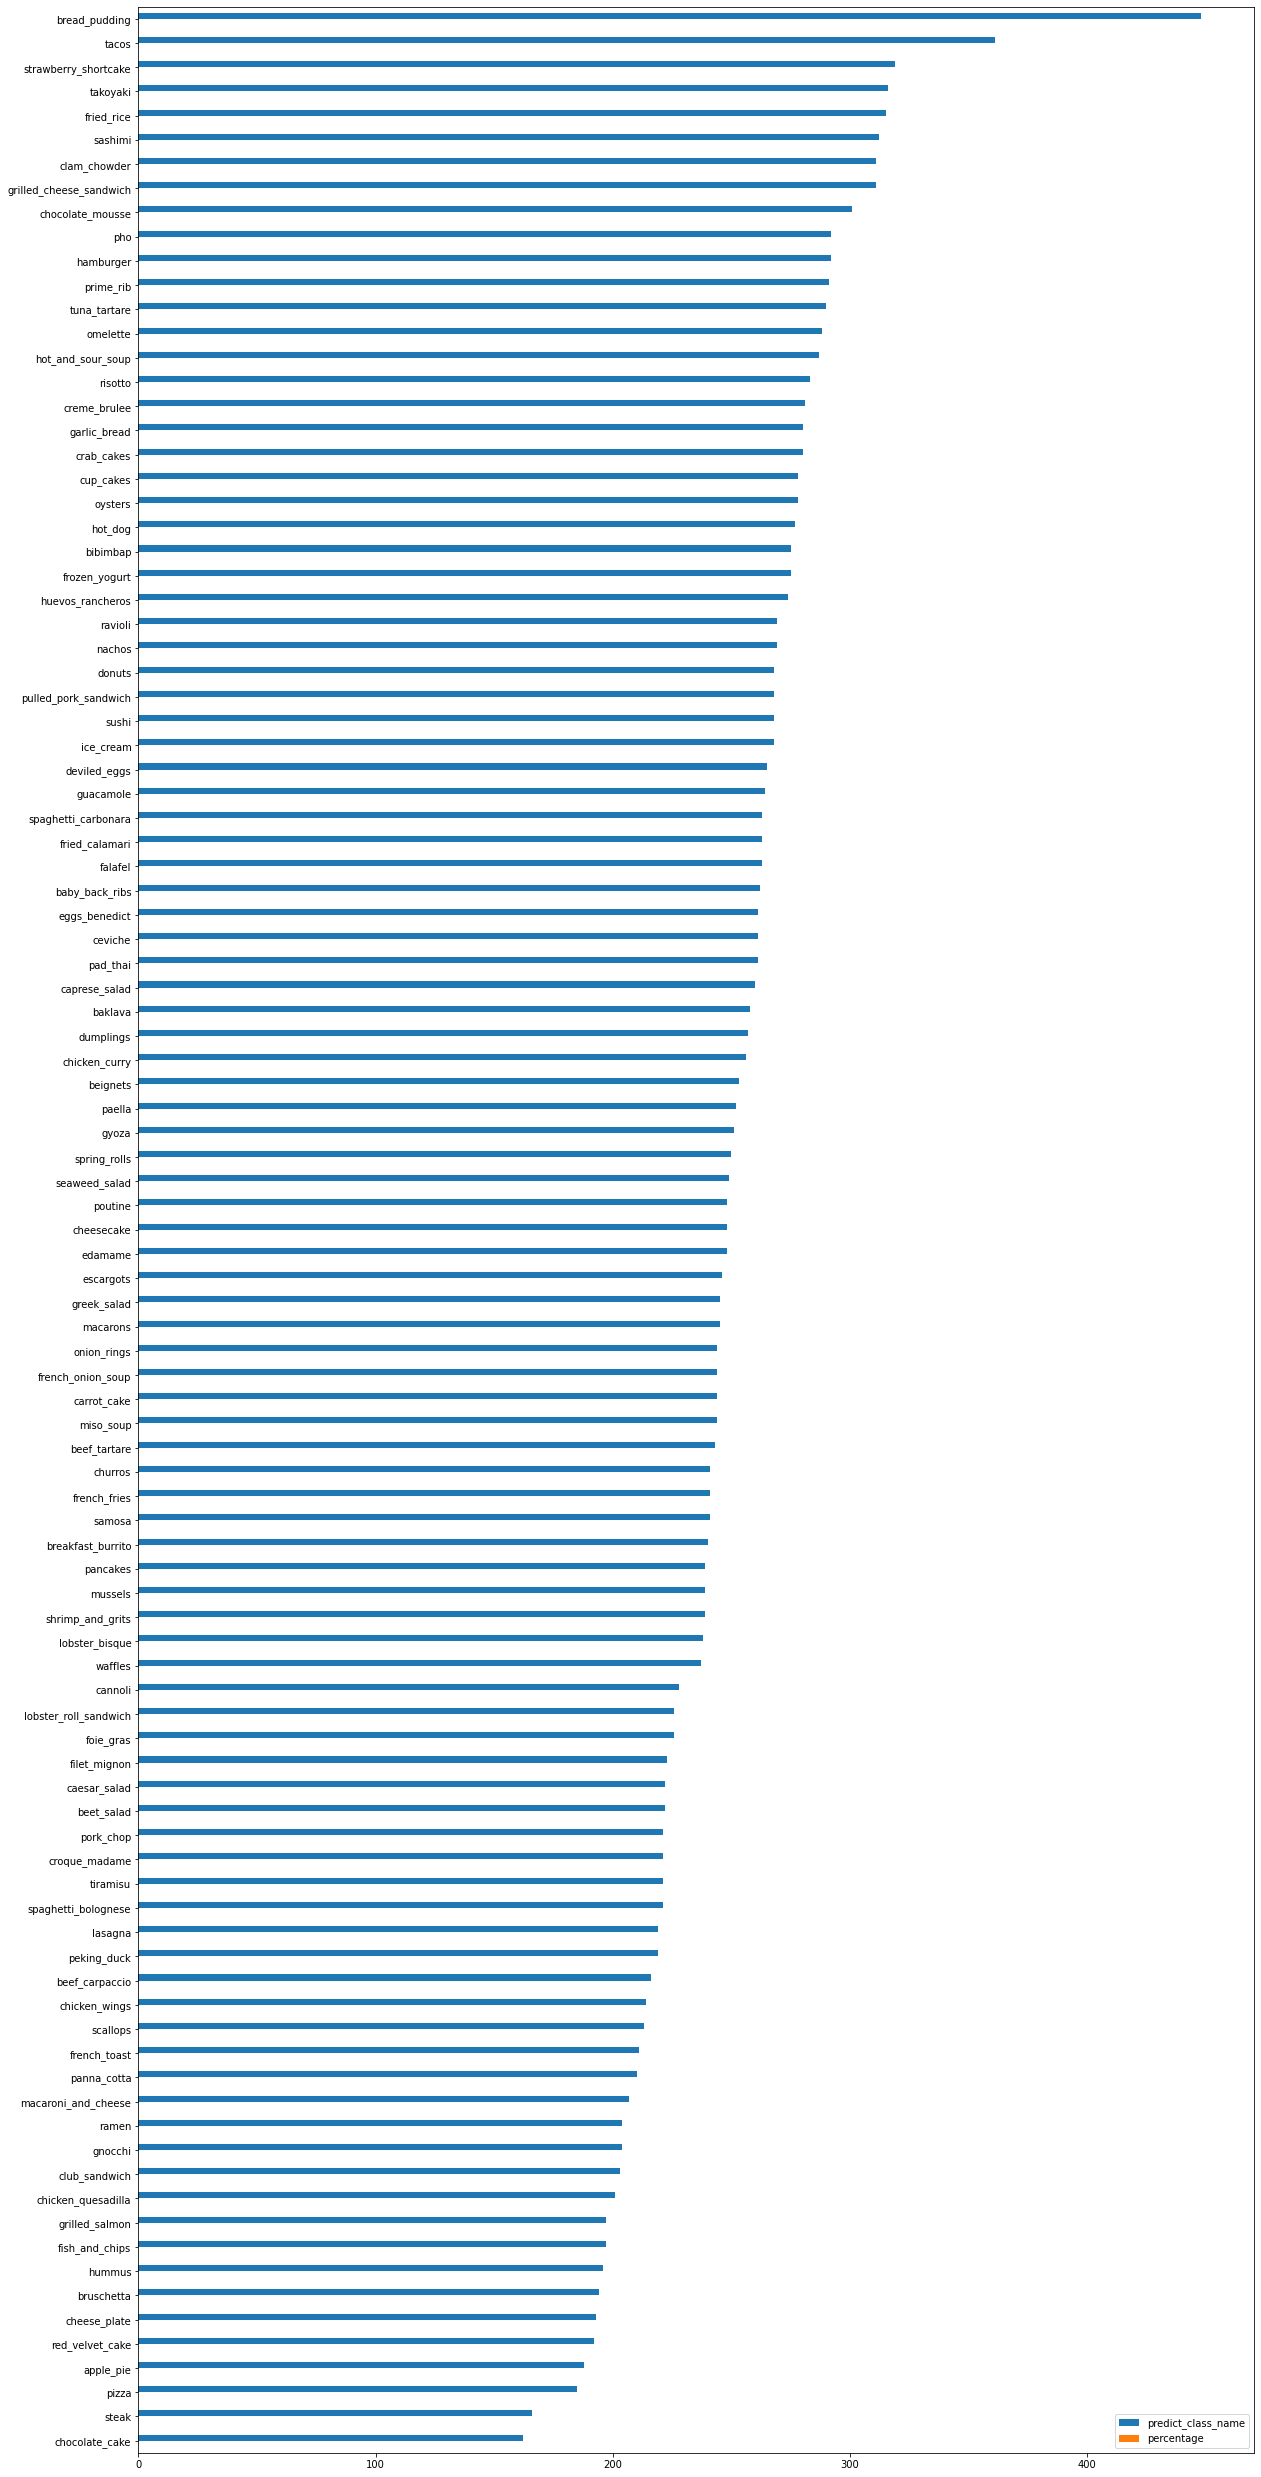

In [ ]:
fig,ax = plt.subplots(figsize=(20,45))
top_most_classes_prediction.plot.barh(ax=ax)
ax.invert_yaxis()

Dự đoán hình ảnh ngẫu nhiên trên tập dữ liệu `test`

Để dự đoán một hình ảnh nào đó, chúng ta cần load và đồng bộ hình ảnh theo một kích thước đã được định sẵn theo mô hình train. VD : mô hình được fit với dữ liệu input là `train_data` có hình dạng là một tuple (`(None, 224, 224, 3), (None,))` có kiểu dữ liệu `(tf.float32, tf.int64)` với mỗi phần tử đại diện cho hình dạng của image và label. 

Vậy thì khi đưa vào `model.predict(data)` thì data trong đó cũng phải là một tuple (`(None, 224, 224, 3), (None,))`. Với `tf.data.Dataset` là  một tensor có chiều đầu tiên là `batch_size`, trong khi image và label chưa được định nghĩa cho chiều đầu tiên đó. Vì vậy chúng ta sẽ sử dụng `tf.expand_dims()` để thêm cho cả image và label chiều đầu tiên là `1`.   Chúng ta sẽ sử dụng phương thức `tf.data.Dataset.from_tensor()` để định nghĩa kiểu dữ liệu cho image và label. Sau đó, sử dụng `tf.data.Dataset.zip()` để chập image và label thành một tuple như mong muốn. Cụ thể như sau : 

+ Load và chuẩn bị hình ảnh
+ Tạo hàm lấy hình ảnh ngẫu nhiên và dự đoán hình ảnh đó.


In [ ]:
import random

def load_and_preprocess_image(image_path, shape=(224,224),norm=False ) : 
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image,channels=3)
  image = tf.image.resize(image, size=(224,224))
  if norm : 
    return image / 255. 
  return image 

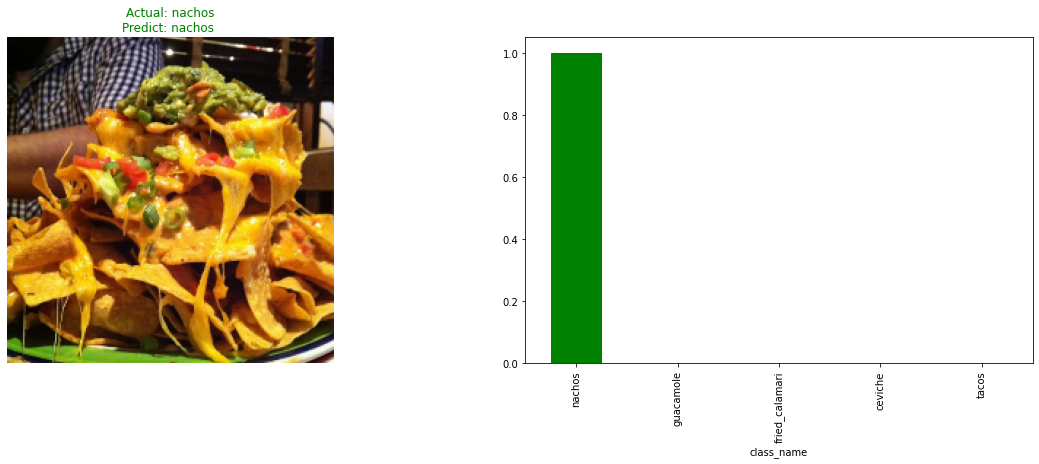

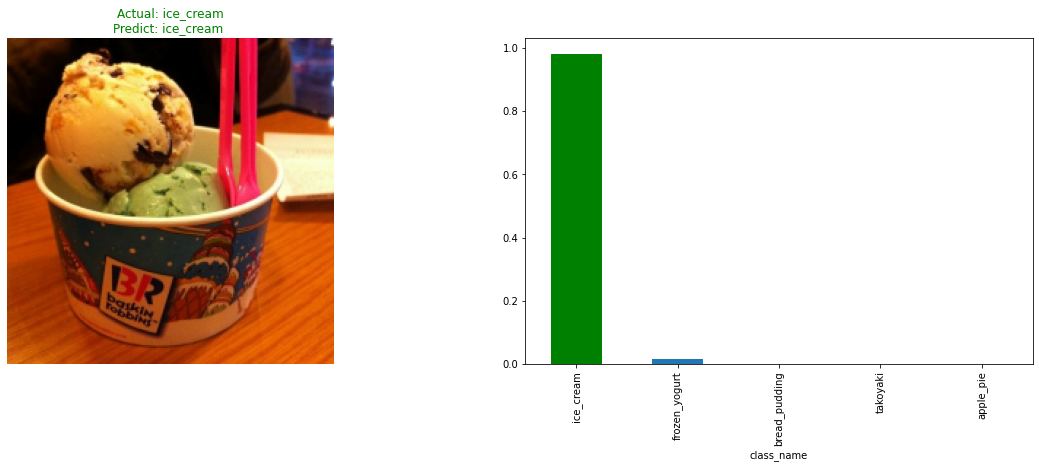

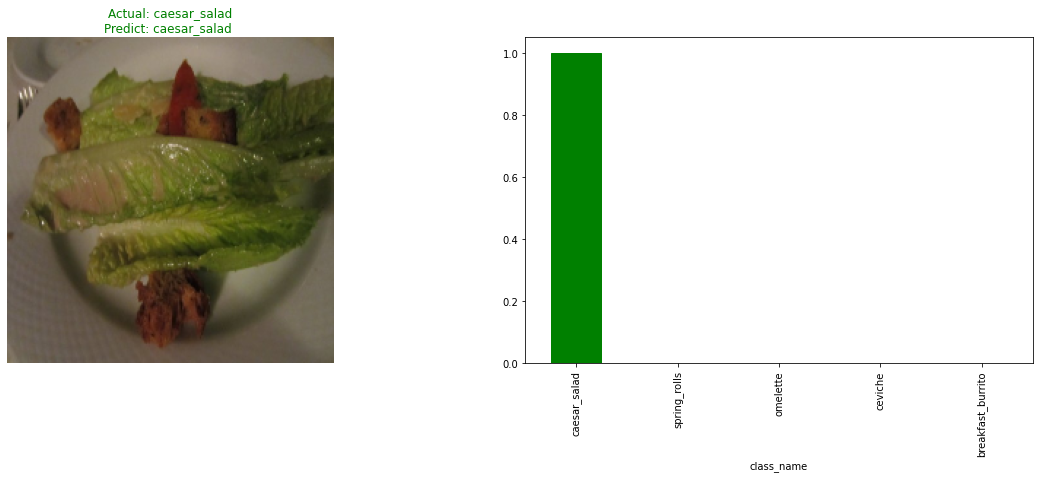

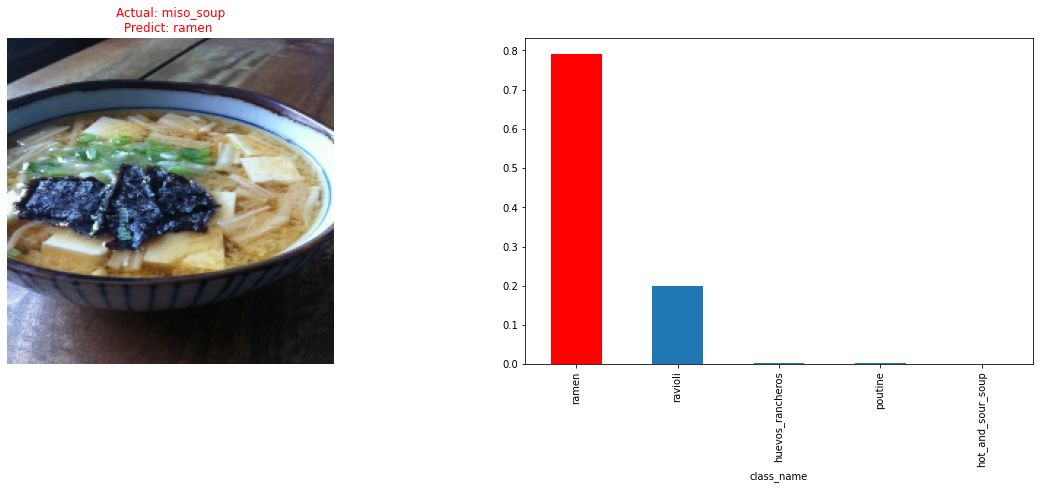

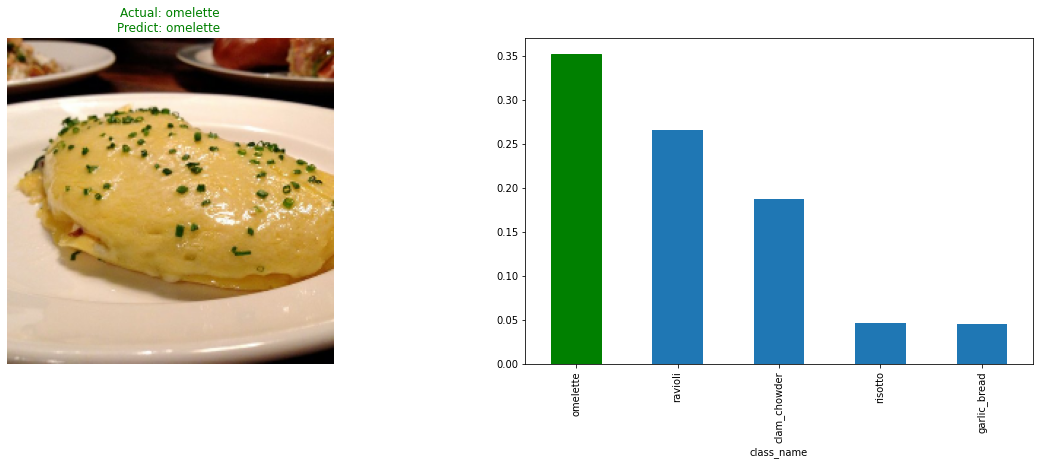

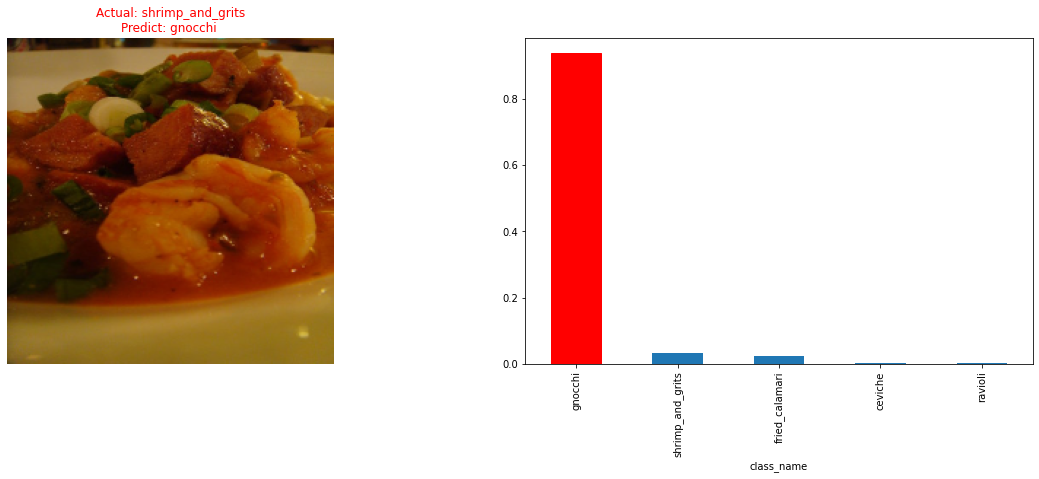

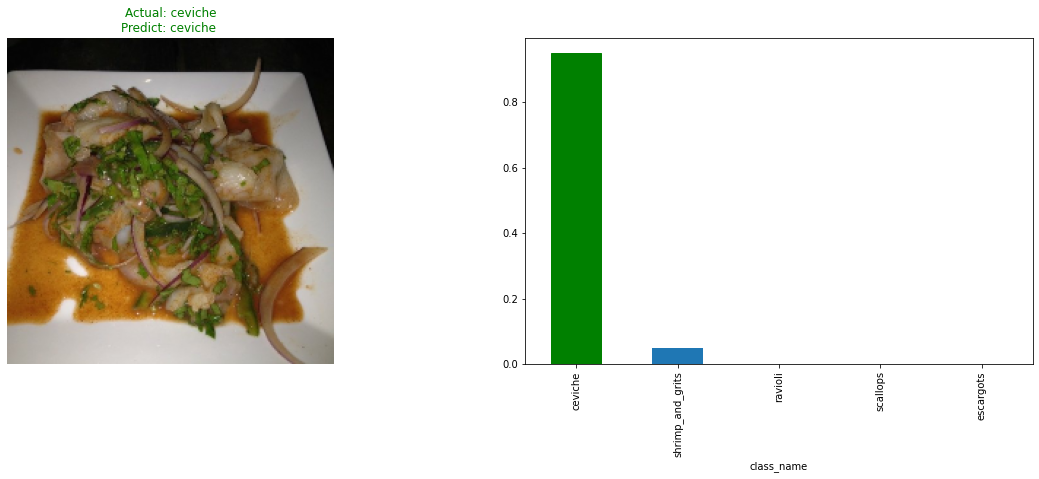

In [ ]:
import random 
import matplotlib.pyplot as plt 

def plot_random_image_and_predict(model, n_samples=1) : 
  if n_samples > 7 : 
    print(f"Số mẫu không vượt quá 7")
    return 
  if n_samples < 1 : 
    n_samples = 7
      
  random_class_names = random.sample(os.listdir(all_classes_test_dir),k=n_samples)
  random_class_dirs = [os.path.join(all_classes_test_dir, class_name) for class_name in random_class_names ]
  for class_dir in random_class_dirs : 
    random_image_name = random.choice(os.listdir(class_dir)) 
    random_image_path = os.path.join(class_dir, random_image_name)
    image_tensor = load_and_preprocess_image(random_image_path)    
    for i, class_name in enumerate(class_names) : 
      if class_name == class_dir.split("/")[-1] : 
        image_label_index = i 
        image_label_name = class_name
    # Tạo input_image_tensor với 4 chiều (batch_size,height, width, color channels )
    input_image_tensor = tf.data.Dataset.from_tensors(tf.expand_dims(image_tensor,axis=0))
    # Tạo label tensor với 2 chiều (batch_size, label-encoded)
    input_label_index = tf.data.Dataset.from_tensors(tf.expand_dims(image_label_index,axis=0))
    # Chập input_image_tensor và input_label_index
    input_tensors = tf.data.Dataset.zip((input_image_tensor,input_label_index))
    
    pred_probs = model.predict(input_tensors)
    pred_label_index = tf.argmax(tf.squeeze(pred_probs)).numpy()    

    color = "red"
    if pred_label_index == image_label_index :
      color = "green"

    pred_df = pd.DataFrame({"class_name" : class_names, "probability" : pred_probs[0]}).sort_values(by="probability",ascending=False)[:5]
    pred_df.set_index("class_name",inplace=True)  
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
    ax1.imshow(image_tensor/255.)
    ax1.axis(False)
    ax1.set_title(f"Actual: {image_label_name}\nPredict: {class_names[pred_label_index]} ", color=color)
    
    pred_df.plot.bar(ax=ax2,legend=False)    
    ax2.get_children()[0].set_color(color)
plot_random_image_and_predict(loaded_model_fine_tune,n_samples=7 )